In [1030]:
import pandas as pd
import os
import re
import indiapins
import numpy as np
from scipy.stats import ttest_ind,ttest_rel
from collections import defaultdict
from tqdm import tqdm
import re
from branca.element import Figure
#pip install indiapins
#pip install indian-pincode-details
#from indian_pincode_details import get_pincode_details
#pip install folium

In [99]:
# from geopy.geocoders import Nominatim
 
# # Using Nominatim Api
# geolocator = Nominatim(user_agent="test")
 
# # Zipcode input
# zipcode = "460001"
 
# # Using geocode()
# location = geolocator.geocode(zipcode)
# def getDistate(zipcode):
#     location = geolocator.geocode(zipcode[3:-3])
#     print(location)
#     filtLoc = re.sub(",", "", location.address)
#     filtLocSplit = filtLoc.split()
#     print(filtLocSplit)
#     if "Tahsil" in filtLocSplit:
#         District = " ".join(filtLocSplit[filtLocSplit.index("Tahsil")+1:filtLocSplit.index("District")])
#         State = " ".join(filtLocSplit[filtLocSplit.index("District")+1:filtLocSplit.index("India")])
#     elif "Taluka" in filtLocSplit:
#         District = " ".join(filtLocSplit[filtLocSplit.index("Taluka")+1:filtLocSplit.index("District")])
#         State = " ".join(filtLocSplit[filtLocSplit.index("District")+1:filtLocSplit.index("India")])
#     else:
#         District =  " ".join(filtLocSplit[-3])
#         State = " ".join(filtLocSplit[-2])
    
#     return District,State

In [ ]:
# def getDistate(zipcode):
#     try:
        
#         District = indiapins.matching(zipcode[3:-3])[0]["District"]
#         State = indiapins.matching(zipcode[3:-3])[0]["State"]
#         Latitude = indiapins.matching(zipcode[3:-3])[0]["Latitude"]
#         Longitude = indiapins.matching(zipcode[3:-3])[0]["Longitude"]

#         return District,State,Latitude,Longitude
#     except:
#         #print(zipcode)
#         return "unknown","unknown"
    
# #df["zipCode"] = df["source_center"].apply(lambda x:x[3:-3])
# #df["DistrictStateLatLong"] = df["source_center"].apply(getDistate)

# Problem Statement:

1. Develop data cleaning, sanitization, and manipulation procedures to extract useful features from raw data fields, enhancing the quality and efficiency of the data.
2. Analyze raw data, derive meaningful insights.leverage the cleaned and processed data to drive business intelligence and competitive advantage.

# Reading file

In [1199]:
df = pd.read_csv("delhivery_data.txt")
df["sourcezipCode"] = df["source_center"].apply(lambda x:x[3:-3])
df["destzipCode"] = df["destination_center"].apply(lambda x:x[3:-3])
uniqueZip = set(df["sourcezipCode"]).union(df["destzipCode"])

# Shape of data

In [1200]:
df.shape

(144867, 26)

# Total Nulls

In [1201]:
df.isnull().any(axis=1).sum()

551

In [1202]:
df.isna().sum()

data                                0
trip_creation_time                  0
route_schedule_uuid                 0
route_type                          0
trip_uuid                           0
source_center                       0
source_name                       293
destination_center                  0
destination_name                  261
od_start_time                       0
od_end_time                         0
start_scan_to_end_scan              0
is_cutoff                           0
cutoff_factor                       0
cutoff_timestamp                    0
actual_distance_to_destination      0
actual_time                         0
osrm_time                           0
osrm_distance                       0
factor                              0
segment_actual_time                 0
segment_osrm_time                   0
segment_osrm_distance               0
segment_factor                      0
sourcezipCode                       0
destzipCode                         0
dtype: int64

## source_name and destination_name has most of the nulls

# Data type of all the attributes

In [1203]:
df.dtypes

data                               object
trip_creation_time                 object
route_schedule_uuid                object
route_type                         object
trip_uuid                          object
source_center                      object
source_name                        object
destination_center                 object
destination_name                   object
od_start_time                      object
od_end_time                        object
start_scan_to_end_scan            float64
is_cutoff                            bool
cutoff_factor                       int64
cutoff_timestamp                   object
actual_distance_to_destination    float64
actual_time                       float64
osrm_time                         float64
osrm_distance                     float64
factor                            float64
segment_actual_time               float64
segment_osrm_time                 float64
segment_osrm_distance             float64
segment_factor                    

## Q what are the Categorical data?

In [1205]:
categorical_cols = []
for column in df.columns:
    if df[column].dtype == 'object' and len(df[column].unique()) < 0.05 * len(df):
        print("Col Name:",column)
        print("unique categories:",df[column].nunique())
        categorical_cols.append(column)
        category_pct_share = df[column].value_counts(normalize=True) * 100
        print(category_pct_share)
        print("="*50)
        

print("Categorical columns:", categorical_cols)

Col Name: data
unique categories: 2
data
training    72.382254
test        27.617746
Name: proportion, dtype: float64
Col Name: route_schedule_uuid
unique categories: 1504
route_schedule_uuid
thanos::sroute:4029a8a2-6c74-4b7e-a6d8-f9e069fbcea9    1.250802
thanos::sroute:0456b740-1dad-4929-bbe0-87d8843f5a10    1.109984
thanos::sroute:dca6268f-741a-4d1a-b1b0-aab13095a366    1.107913
thanos::sroute:a1b25549-1e77-498f-8538-00292e5bd5a2    0.887021
thanos::sroute:de5e208e-7641-45e6-8100-4d9fb1e5720d    0.883569
                                                         ...   
thanos::sroute:d563d17e-2123-40a4-9eec-40018966caba    0.000690
thanos::sroute:036f372d-28d8-4d19-877c-6277077ad09e    0.000690
thanos::sroute:e00eb6aa-d792-4b28-81fa-fdee413ef326    0.000690
thanos::sroute:889b9cf5-da6a-48ce-b3bd-6983c8090164    0.000690
thanos::sroute:404cbabf-d2a5-4e46-bf79-8b3c518f082b    0.000690
Name: proportion, Length: 1504, dtype: float64
Col Name: route_type
unique categories: 2
route_type
FTL 

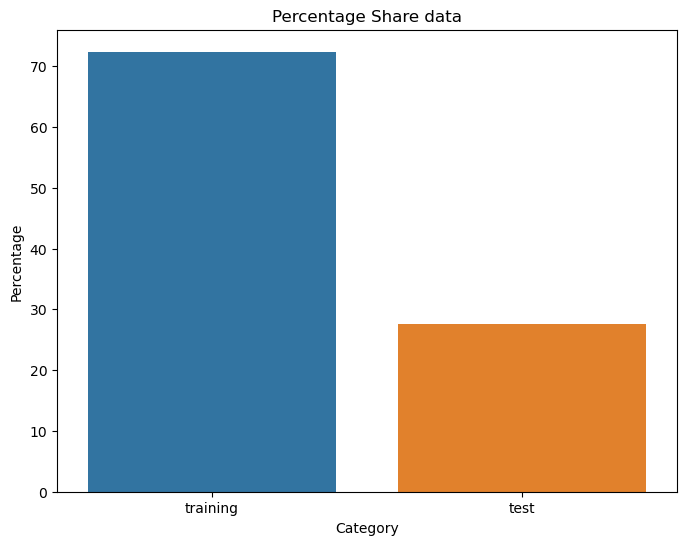

In [1209]:
category_pct_share = df["data"].value_counts(normalize=True) * 100
category_pct_df = category_pct_share.reset_index()
category_pct_df.columns = ['Category', 'Percentage']

# Create bar plot
plt.figure(figsize=(8, 6))
sns.barplot(data=category_pct_df, x='Category', y='Percentage')
plt.title('Percentage Share data')
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.show()

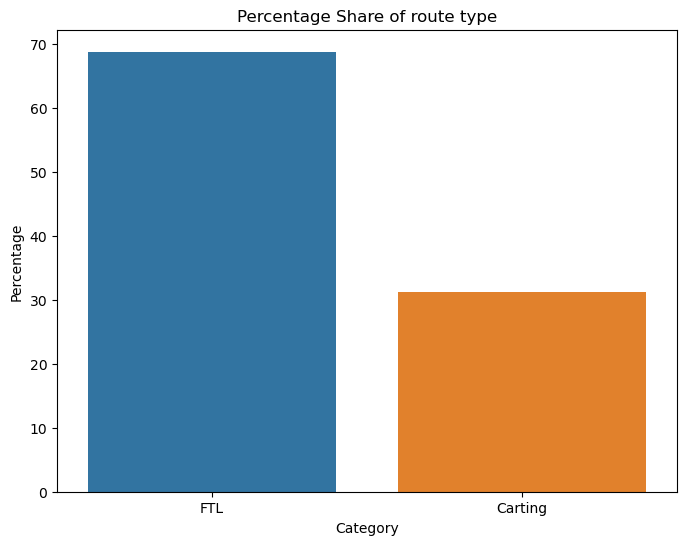

In [1210]:
category_pct_share = df["route_type"].value_counts(normalize=True) * 100
category_pct_df = category_pct_share.reset_index()
category_pct_df.columns = ['Category', 'Percentage']
plt.figure(figsize=(8, 6))
sns.barplot(data=category_pct_df, x='Category', y='Percentage')
plt.title('Percentage Share of route type')
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.show()

# converting categorical data to category

In [1211]:
df[categorical_cols] = df[categorical_cols].astype('category')

In [1212]:
df.dtypes

data                              category
trip_creation_time                  object
route_schedule_uuid               category
route_type                        category
trip_uuid                           object
source_center                     category
source_name                       category
destination_center                category
destination_name                  category
od_start_time                       object
od_end_time                         object
start_scan_to_end_scan             float64
is_cutoff                             bool
cutoff_factor                        int64
cutoff_timestamp                    object
actual_distance_to_destination     float64
actual_time                        float64
osrm_time                          float64
osrm_distance                      float64
factor                             float64
segment_actual_time                float64
segment_osrm_time                  float64
segment_osrm_distance              float64
segment_fac

# summary of Data

In [1213]:
summary = df.describe(include='all')

# Print the summary
summary

data          trip_creation_time  \
count     144867                      144867   
unique         2                       14817   
top     training  2018-09-28 05:23:15.359220   
freq      104858                         101   
mean         NaN                         NaN   
std          NaN                         NaN   
min          NaN                         NaN   
25%          NaN                         NaN   
50%          NaN                         NaN   
75%          NaN                         NaN   
max          NaN                         NaN   

                                      route_schedule_uuid route_type  \
count                                              144867     144867   
unique                                               1504          2   
top     thanos::sroute:4029a8a2-6c74-4b7e-a6d8-f9e069f...        FTL   
freq                                                 1812      99660   
mean                                                  NaN        NaN   
std                                                   NaN        NaN   
min                                                   NaN        NaN   
25%                                                   NaN        NaN   
50%                                                   NaN        NaN   
75%                                                   NaN        NaN   
max                                                   NaN        NaN   

                      trip_uuid source_center                    source_name  \
count                    144867        144867                         144574   
unique                    14817          1508                           1498   
top     trip-153811219535896559  IND000000ACB  Gurgaon_Bilaspur_HB (Haryana)   
freq                        101         23347                          23347   
mean                        NaN           NaN                            NaN   
std                         NaN           NaN                            NaN   
min                         NaN           NaN                            NaN   
25%                         NaN           NaN                            NaN   
50%                         NaN           NaN                            NaN   
75%                         NaN           NaN                            NaN   
max                         NaN           NaN                            NaN   

       destination_center               destination_name  \
count              144867                         144606   
unique               1481                           1468   
top          IND000000ACB  Gurgaon_Bilaspur_HB (Haryana)   
freq                15192                          15192   
mean                  NaN                            NaN   
std                   NaN                            NaN   
min                   NaN                            NaN   
25%                   NaN                            NaN   
50%                   NaN                            NaN   
75%                   NaN                            NaN   
max                   NaN                            NaN   

                     od_start_time  ...    actual_time      osrm_time  \
count                       144867  ...  144867.000000  144867.000000   
unique                       26369  ...            NaN            NaN   
top     2018-09-21 18:37:09.322207  ...            NaN            NaN   
freq                            81  ...            NaN            NaN   
mean                           NaN  ...     416.927527     213.868272   
std                            NaN  ...     598.103621     308.011085   
min                            NaN  ...       9.000000       6.000000   
25%                            NaN  ...      51.000000      27.000000   
50%                            NaN  ...     132.000000      64.000000   
75%                            NaN  ...     513.000000     257.000000   
max                            NaN  ...    4532.000000    1686.000000   

        osr

# extracting zipcode and creating dictionary

In [1214]:
pinMapping = defaultdict(dict)
pinIssues = set()
for i in tqdm(uniqueZip):
    try:
        pinMapping[i]["District"] = indiapins.matching(i)[0]["District"]
        pinMapping[i]["State"] = indiapins.matching(i)[0]["State"]
        pinMapping[i]["Latitude"] = indiapins.matching(i)[0]["Latitude"]
        pinMapping[i]["Longitude"] = indiapins.matching(i)[0]["Longitude"]
    except:
        pinIssues.add(i)

100%|██████████████████████████████████████████████████████████████████████████████| 1515/1515 [05:52<00:00,  4.30it/s]


In [1215]:
pinMapping["852118"]["District"] = "Forbesganj"
pinMapping["852118"]["State"] = "Bihar"
pinMapping["852118"]["Latitude"] = np.nan
pinMapping["852118"]["Longitude"] = np.nan

# No records for zip codes

In [1216]:
pinIssues

{'000000',
 '122050',
 '142401',
 '205135',
 '212501',
 '263002',
 '263401',
 '275503',
 '302014',
 '302023',
 '382715',
 '384205',
 '396232',
 '401104',
 '421802',
 '441603',
 '462021',
 '492007',
 '509124',
 '632402',
 '68004',
 '686028',
 '713364',
 '811399',
 '852118'}

# ===============================================================

# HANDLING Nans

In [1217]:
print("Total nans in source_name:",df[df[["source_center","source_name"]].isna().any(axis=1)].shape[0])
missingSourceName = df[df[["source_center","source_name"]].isna().any(axis=1)]["source_center"].unique()
print("zip code missing source_name:\n",missingSourceName)

Total nans in source_name: 293
zip code missing source_name:
 ['IND342902A1B', 'IND577116AAA', 'IND282002AAD', 'IND465333A1B', 'IND841301AAC', 'IND509103AAC', 'IND126116AAA', 'IND331022A1B', 'IND505326AAB', 'IND852118A1B']
Categories (1508, object): ['IND000000AAL', 'IND000000AAQ', 'IND000000AAS', 'IND000000AAZ', ..., 'IND854311AAA', 'IND854326AAB', 'IND854334AAA', 'IND854335AAA']


## extracting source name via source center

In [1218]:
for i in missingSourceName:
    if len(pinMapping[i[3:-3]]):
    #print(df[df["source_center"]==i][["source_center","source_name"]])
        df["source_name"] = np.where(df["source_center"]==i,pinMapping[i[3:-3]]["District"]+"_"+"({})".format(pinMapping[i[3:-3]]["State"]),df["source_name"])
    #print(df[df["source_center"]==i][["source_center","source_name"]])

# No nulls in source name

In [1219]:
df[df[["source_center","source_name"]].isna().any(axis=1)].shape[0]

0

In [1220]:
df.shape

(144867, 26)

# dropping 3 rows as could not get from india pins as well as source name is nan

In [1221]:
df.dropna(subset=["source_center","source_name"],inplace=True)

In [1222]:
df.shape

(144867, 26)

# Nan destination Name

In [1223]:
df.shape

(144867, 26)

In [1224]:
print("Number of nulls in destination_name",df[df[["destination_center","destination_name"]].isna().any(axis=1)]["destination_center"].shape[0])
missingDestName = df[df[["destination_center","destination_name"]].isna().any(axis=1)]["destination_center"].unique()
for i in missingDestName:
    if len(pinMapping[i[3:-3]]):
    #print(df[df["source_center"]==i][["source_center","source_name"]])
        df["destination_name"] = np.where(df["destination_center"]==i,pinMapping[i[3:-3]]["District"]+"_"+"({})".format(pinMapping[i[3:-3]]["State"]),df["destination_name"])
    #print(df[df["source_center"]==i][["source_center","source_name"]])

Number of nulls in destination_name 261


## Nulls check

In [1225]:
df[df[["destination_center","destination_name"]].isna().any(axis=1)]["destination_center"].shape[0]

0

# dropping 15 rows as could not get from india pins as well as dest name is nan

In [1226]:
df.dropna(subset=["destination_center","destination_name"],inplace=True)

In [1227]:
df.shape

(144867, 26)

In [1228]:
df[df[["destination_center","destination_name"]].isna().any(axis=1)][["destination_center","destination_name"]]

Empty DataFrame
Columns: [destination_center, destination_name]
Index: []

# ADDING Features sourceDistrict,sourceState,destDistrict,destState,sourceLatitude,destLatitude,sourceLongitude,destLongitude

# assigning state,city via pins

In [1229]:
df["sourceDistrict"] = ""
df["sourceState"] = ""
df["sourceLatitude"] = ""
df["sourceLongitude"] = ""

df["destDistrict"] = ""
df["destState"] = ""
df["destLatitude"] = ""
df["destLongitude"] = ""

In [1230]:
for i in tqdm(pinMapping):
    try:
        df["sourceDistrict"] = np.where(df["sourcezipCode"]==i,pinMapping[i]["District"],df["sourceDistrict"])
        df["destDistrict"] = np.where(df["destzipCode"]==i,pinMapping[i]["District"],df["destDistrict"])

        df["sourceState"] = np.where(df["sourcezipCode"]==i,pinMapping[i]["State"],df["sourceState"])
        df["destState"] = np.where(df["destzipCode"]==i,pinMapping[i]["State"],df["sourceState"])

        df["sourceLatitude"] = np.where(df["sourcezipCode"]==i,pinMapping[i]["Latitude"],df["sourceLatitude"])
        df["destLatitude"] = np.where(df["destzipCode"]==i,pinMapping[i]["Latitude"],df["destLatitude"])

        df["sourceLongitude"] = np.where(df["sourcezipCode"]==i,pinMapping[i]["Longitude"],df["sourceLongitude"])
        df["destLongitude"] = np.where(df["destzipCode"]==i,pinMapping[i]["Longitude"],df["destLongitude"])
    except:
        print(i)

100%|██████████████████████████████████████████████████████████████████████████████| 1491/1491 [00:43<00:00, 34.29it/s]


In [689]:
df.shape

(144867, 34)

# Missing District and state case

## extracting district and state out from source name and destination name

In [1231]:
y = set(df[df["destDistrict"]==""]["destzipCode"].unique()).union(set(df[df["sourceDistrict"]==""]["sourcezipCode"].unique()))

In [1232]:
missingDf = df[(df["sourcezipCode"].isin(pinIssues)) | (df["destzipCode"].isin(pinIssues))][["source_center","source_name","destination_center","destination_name"]].drop_duplicates()
#missingDf.dropna(inplace=True)

In [1233]:
pinIssue = defaultdict(dict)
for i in set(missingDf["source_name"]).union(set(missingDf["destination_name"])):
    pinIssue[i]["State"] = re.findall(r'\((.*?)\)',i)[0]
    pinIssue[i]["District"] = i.split("_")[0]
    
for i in missingDf["source_name"]:
    df["sourceDistrict"] = np.where(df["source_name"]==i,pinIssue[i]["District"],df["sourceDistrict"])
    df["sourceState"] = np.where(df["source_name"]==i,pinIssue[i]["State"],df["sourceState"])
    
for i in missingDf["destination_name"]:
    df["destDistrict"] = np.where(df["destination_name"]==i,pinIssue[i]["District"],df["destDistrict"])
    df["destState"] = np.where(df["destination_name"]==i,pinIssue[i]["State"],df["destState"])

In [795]:
# missingDf["sourceState"] = missingDf["source_name"].apply(lambda x:re.findall(r'\((.*?)\)',x)[0])
# missingDf["destState"] = missingDf["destination_name"].apply(lambda x:re.findall(r'\((.*?)\)',x)[0])

# missingDf["sourceDistrict"] = missingDf["source_name"].apply(lambda x:x.split("_")[0])
# missingDf["destDistrict"] = missingDf["destination_name"].apply(lambda x:x.split("_")[0])

In [796]:
#testing
#df[(df["destzipCode"]=="000000") & (df["sourcezipCode"]=="000000")]

#### In the above code missing values in source_name and destination is handled via zipcodes using regex

# Checking for any null,blank values

In [1234]:
df[df["sourceDistrict"]==""]

Empty DataFrame
Columns: [data, trip_creation_time, route_schedule_uuid, route_type, trip_uuid, source_center, source_name, destination_center, destination_name, od_start_time, od_end_time, start_scan_to_end_scan, is_cutoff, cutoff_factor, cutoff_timestamp, actual_distance_to_destination, actual_time, osrm_time, osrm_distance, factor, segment_actual_time, segment_osrm_time, segment_osrm_distance, segment_factor, sourcezipCode, destzipCode, sourceDistrict, sourceState, sourceLatitude, sourceLongitude, destDistrict, destState, destLatitude, destLongitude]
Index: []

[0 rows x 34 columns]

In [1235]:
df[df["sourceState"]==""]

Empty DataFrame
Columns: [data, trip_creation_time, route_schedule_uuid, route_type, trip_uuid, source_center, source_name, destination_center, destination_name, od_start_time, od_end_time, start_scan_to_end_scan, is_cutoff, cutoff_factor, cutoff_timestamp, actual_distance_to_destination, actual_time, osrm_time, osrm_distance, factor, segment_actual_time, segment_osrm_time, segment_osrm_distance, segment_factor, sourcezipCode, destzipCode, sourceDistrict, sourceState, sourceLatitude, sourceLongitude, destDistrict, destState, destLatitude, destLongitude]
Index: []

[0 rows x 34 columns]

In [1236]:
df[df["destDistrict"]==""]

Empty DataFrame
Columns: [data, trip_creation_time, route_schedule_uuid, route_type, trip_uuid, source_center, source_name, destination_center, destination_name, od_start_time, od_end_time, start_scan_to_end_scan, is_cutoff, cutoff_factor, cutoff_timestamp, actual_distance_to_destination, actual_time, osrm_time, osrm_distance, factor, segment_actual_time, segment_osrm_time, segment_osrm_distance, segment_factor, sourcezipCode, destzipCode, sourceDistrict, sourceState, sourceLatitude, sourceLongitude, destDistrict, destState, destLatitude, destLongitude]
Index: []

[0 rows x 34 columns]

In [1237]:
df[df["destState"]==""]

Empty DataFrame
Columns: [data, trip_creation_time, route_schedule_uuid, route_type, trip_uuid, source_center, source_name, destination_center, destination_name, od_start_time, od_end_time, start_scan_to_end_scan, is_cutoff, cutoff_factor, cutoff_timestamp, actual_distance_to_destination, actual_time, osrm_time, osrm_distance, factor, segment_actual_time, segment_osrm_time, segment_osrm_distance, segment_factor, sourcezipCode, destzipCode, sourceDistrict, sourceState, sourceLatitude, sourceLongitude, destDistrict, destState, destLatitude, destLongitude]
Index: []

[0 rows x 34 columns]

In [1238]:
df[["source_center","source_name"]][df[["source_center","source_name"]].isnull().any(axis=1)]

Empty DataFrame
Columns: [source_center, source_name]
Index: []

In [1239]:
# Mapping = dict()
# for i in set(df[["source_center","source_name"]][df[["source_center","source_name"]].isnull().any(axis=1)]["source_center"].unique()).union(df[["destination_center","destination_name"]][df[["destination_center","destination_name"]].isnull().any(axis=1)]["destination_center"].unique()):
#     try:
#         Mapping[i] = indiapins.matching(i[3:-3])[0]["District"]
#     except:
#         Mapping[i] = "unknown"
        
# for i in Mapping:
#     df["source_name"] = np.where(df["source_center"]==i,Mapping[i],df["source_name"])
#     df["destination_name"] = np.where(df["destination_center"]==i,Mapping[i],df["destination_name"])

# Creating Features

In [1240]:
df["trip_creation_time"] = pd.to_datetime(df["trip_creation_time"])
df["trip_year"] = df["trip_creation_time"].apply(lambda x:x.year)
df["trip_month"] = df["trip_creation_time"].apply(lambda x:x.month)
df["trip_week"] = df["trip_creation_time"].apply(lambda x:x.week)

# Range of data

In [1241]:
print("MAX year: ",max(df["trip_year"]))
print("MIN year: ",min(df["trip_year"]))
print("="*50)
print("MAX month: ",max(df["trip_month"]))
print("MIN month: ",min(df["trip_month"]))
print("="*50)
print("MAX week: ",max(df["trip_week"]))
print("MIN week: ",min(df["trip_week"]))

MAX year:  2018
MIN year:  2018
MAX month:  10
MIN month:  9
MAX week:  40
MIN week:  37


# Visual Analysis

In [1398]:
df["segment"] = df["trip_uuid"] + df["source_name"] + df["destination_name"]
vis = df.groupby(["segment"]).agg({"route_type":"first",
                            "actual_time":"last",
                            "source_name":"first",
                            "sourceDistrict":"first",
                             "sourceState":"first",
                             "destination_name":"first",
                            "destDistrict":"first",
                             "destState":"first",
                            "sourceLatitude":"first",
                            "sourceLongitude":"first",
                            "destLatitude":"first",
                            "destLongitude":"first"
                            }).reset_index()

vis = (df.groupby(["segment"]).
             agg({"source_name":"first",
            "route_type":"first",
            "sourceDistrict":"first",
            "sourceState":"first",
            "destination_name":"first",
            "destDistrict":"first",
            "destState":"first",
            "start_scan_to_end_scan":"first",
            "actual_time":"last",
            "osrm_time":"last",
            "osrm_distance":"last",
            "segment_actual_time":"sum",
            "segment_osrm_time":"sum",
            "segment_osrm_distance":"sum",
                 "trip_time_inhr":"last"}).
             reset_index())

# Trip pct share by route type

<Axes: ylabel='segment'>

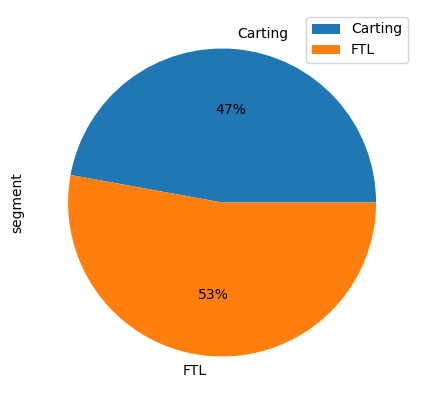

In [1399]:
x = vis.groupby(["route_type"]).agg({"segment":"count"})
x.plot.pie(y='segment', figsize=(5, 5),autopct='%1.0f%%')

In [1417]:
route = vis.groupby(["route_type","source_name","destination_name"]).agg({"segment":"count"}).reset_index()

In [1418]:
carting = route[route["route_type"]=="Carting"].sort_values(by=["segment"],ascending=False)
FTL = route[route["route_type"]=="FTL"].sort_values(by=["segment"],ascending=False)

carting["pct"] = (carting["segment"]/sum(carting["segment"]))*100
FTL["pct"] = (FTL["segment"]/sum(FTL["segment"]))*100

## For 4.89 % of carting orders bagalore airport is either source or destination.

In [1419]:
sum(carting[(carting["source_name"]=="Bengaluru_KGAirprt_HB (Karnataka)") | (carting["destination_name"]=="Bengaluru_KGAirprt_HB (Karnataka)")]["pct"])

4.899831040308953

## For 18 % of carting orders karnataka is either source or destination.

In [1396]:
sum(carting[(carting["source_name"].str.contains("Karnataka")) | (carting["destination_name"].str.contains("Karnataka"))]["pct"])

18.014321345240976

## For 19 % of the carting orders Maharashtra is either source or destination

In [1397]:
sum(carting[(carting["source_name"].str.contains("Maharashtra")) | (carting["destination_name"].str.contains("Maharashtra"))]["pct"])

19.478638667632193

# mean of time and distance for route type

In [1408]:
for i in vis.columns[-7:]:
    print(vis.groupby(["route_type"]).agg({i:"mean"}))
    print("==========================")

            actual_time
route_type             
Carting       90.165098
FTL          299.242198
             osrm_time
route_type            
Carting      33.978920
FTL         141.251381
            osrm_distance
route_type               
Carting         37.550662
FTL            183.733272
            segment_actual_time
route_type                     
Carting               89.133880
FTL                  296.705431
            segment_osrm_time
route_type                   
Carting             38.372757
FTL                158.131717
            segment_osrm_distance
route_type                       
Carting                 41.760811
FTL                    200.023423
            trip_time_inhr
route_type                
Carting           2.914038
FTL               5.109237


In [1441]:
route = vis.groupby(["route_type","source_name","destination_name"]).agg({"actual_time":"last",
                                                                         "segment_osrm_distance":"sum"}).reset_index().dropna()
carting = route[route["route_type"]=="Carting"]
FTL = route[route["route_type"]=="FTL"]

In [1442]:
carting.sort_values(by=["actual_time"],ascending=False).head(5)

route_type                          source_name  \
1657223    Carting  Pappadahandi_Central_DPP_2 (Orissa)   
775982     Carting     Gonda_KotwaliN_D (Uttar Pradesh)   
1065682    Carting          Kanchipuram_DC (Tamil Nadu)   
1410577    Carting    Mokokchung_Central_D_1 (Nagaland)   
1706136    Carting   Phulpur_Shekhpur_D (Uttar Pradesh)   

                                   destination_name  actual_time  \
1657223  Visakhapatnam_Gajuwaka_IP (Andhra Pradesh)       2541.0   
775982       Tulsipur_Central_DPP_1 (Uttar Pradesh)       2536.0   
1065682             MAA_Poonamallee_HB (Tamil Nadu)       1649.0   
1410577                   Jorhat_RicMilRd_D (Assam)       1286.0   
1706136       Allahabad_Central_H_1 (Uttar Pradesh)       1138.0   

         segment_osrm_distance  
1657223               679.8809  
775982                 70.6945  
1065682                95.9113  
1410577               862.4386  
1706136               680.8719

In [1445]:
FTL.sort_values(by=["actual_time"],ascending=False).head(5)

route_type                       source_name  \
2655548        FTL    Chandigarh_Mehmdpur_H (Punjab)   
3427237        FTL  Kolkata_Dankuni_HB (West Bengal)   
2804066        FTL           Delhi_Airport_H (Delhi)   
3049746        FTL              Guwahati_Hub (Assam)   
2405928        FTL  Bangalore_Nelmngla_H (Karnataka)   

                          destination_name  actual_time  segment_osrm_distance  
2655548   Bangalore_Nelmngla_H (Karnataka)       3784.0              2500.2145  
3427237  Bhiwandi_Mankoli_HB (Maharashtra)       3364.0             11816.6479  
2804066               Guwahati_Hub (Assam)       3306.0              2181.4607  
3049746            Delhi_Airport_H (Delhi)       3246.0             39108.7917  
2405928   Kolkata_Dankuni_HB (West Bengal)       3044.0              5916.2280

# creating feature trip_time_inhr

In [1280]:
df["end-start"] = (pd.to_datetime(df["od_end_time"]) - pd.to_datetime(df["od_start_time"]))
df["trip_time_inhr"] = (df["end-start"].dt.components["hours"]) + (df["end-start"].dt.components["minutes"]/60)
df["trip_time_inhr"].mean()

7.15178347495749

In [1309]:
segment = (df.groupby(["segment"]).
             agg({"source_name":"first",
            "route_type":"first",
            "sourceDistrict":"first",
            "sourceState":"first",
            "destination_name":"first",
            "destDistrict":"first",
            "destState":"first",
            "start_scan_to_end_scan":"first",
            "actual_time":"last",
            "osrm_time":"last",
            "osrm_distance":"last",
            "segment_actual_time":"sum",
            "segment_osrm_time":"sum",
            "segment_osrm_distance":"sum",
                 "trip_time_inhr":"last"}).
             reset_index())

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'actual_time'),
  Text(1, 0, 'segment_actual_time'),
  Text(2, 0, 'osrm_time'),
  Text(3, 0, 'segment_osrm_time'),
  Text(4, 0, 'trip_time_inhr'),
  Text(5, 0, 'segment_osrm_distance'),
  Text(6, 0, 'osrm_distance')])

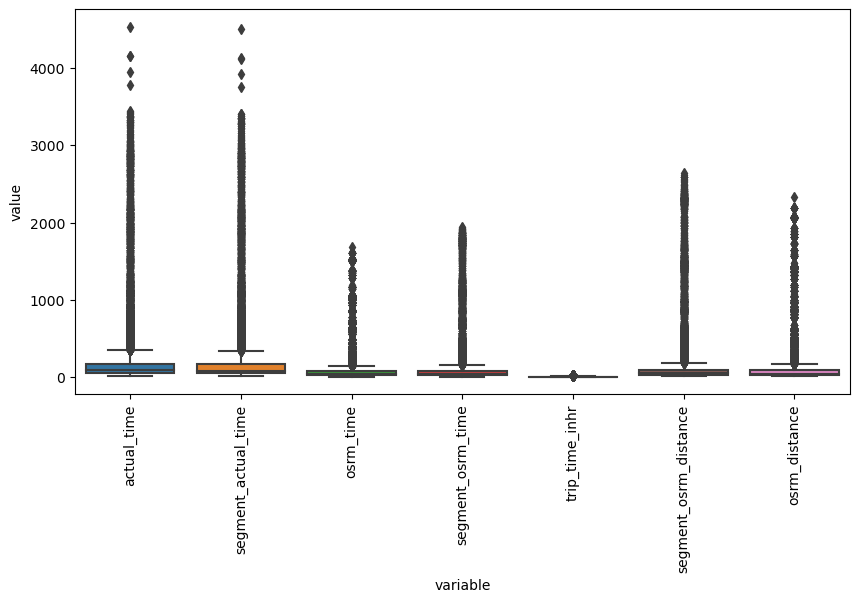

In [1284]:
fig= plt.figure(figsize=(10,5))
melt = pd.melt(segment[['actual_time','segment_actual_time', 'osrm_time', 'segment_osrm_time','trip_time_inhr','segment_osrm_distance','osrm_distance','']])
sns.boxplot(x='variable', y='value', data=melt)
plt.xticks(rotation=90)

1. There's around 9-11 % of outlers in each of the continuous variable.
2. If we think about it , they are not the outlier, its just that for few instances the distance was too high or the time was too high.
3. If we reall want to remove them we can replace the values with the help of IQR threshold

# Outlier detection

In [1288]:
def percentiles(df,col):
    
    print("processing col : ",col)
    print("25th percentile :",np.percentile(df[col],25))
    print("75th percentile :",np.percentile(df[col],75))
    IQR = np.percentile(df[col],75) - np.percentile(df[col],25)
    print("IQR:",IQR)
    minOut = np.percentile(df[col],25) - (1.5*IQR)
    maxOut = np.percentile(df[col],75) + (1.5*IQR)
    
    
    print("values less than {} are consiered as outlier".format(minOut))
    print("values more than {} are consiered as outlier".format(maxOut))
    print("PCT of outliers :",(df[df[col]>=maxOut].shape[0]/df.shape[0])*100)
    
    print("=======================================================")

for i in ['actual_time','segment_actual_time', 'osrm_time', 'segment_osrm_time','trip_time_inhr','segment_osrm_distance','osrm_distance']:
    percentiles(segment,i)

processing col :  actual_time
25th percentile : 51.0
75th percentile : 168.0
IQR: 117.0
values less than -124.5 are consiered as outlier
values more than 343.5 are consiered as outlier
PCT of outliers : 11.95388349514563
processing col :  segment_actual_time
25th percentile : 50.0
75th percentile : 166.0
IQR: 116.0
values less than -124.0 are consiered as outlier
values more than 340.0 are consiered as outlier
PCT of outliers : 11.984223300970873
processing col :  osrm_time
25th percentile : 25.0
75th percentile : 72.0
IQR: 47.0
values less than -45.5 are consiered as outlier
values more than 142.5 are consiered as outlier
PCT of outliers : 11.070236650485436
processing col :  segment_osrm_time
25th percentile : 25.0
75th percentile : 79.0
IQR: 54.0
values less than -56.0 are consiered as outlier
values more than 160.0 are consiered as outlier
PCT of outliers : 12.010770631067961
processing col :  trip_time_inhr
25th percentile : 1.5
75th percentile : 4.933333333333334
IQR: 3.433333333

In [1291]:
import copy
tempSegment = copy.deepcopy(segment)

In [1292]:
def percentiles(df,col):
    
    print("processing col : ",col)
    print("25th percentile :",np.percentile(df[col],25))
    print("75th percentile :",np.percentile(df[col],75))
    IQR = np.percentile(df[col],75) - np.percentile(df[col],25)
    print("IQR:",IQR)
    minOut = np.percentile(df[col],25) - (1.5*IQR)
    maxOut = np.percentile(df[col],75) + (1.5*IQR)
    
    df[col] = np.where(df[col]>=maxOut,maxOut,df[col])
    df[col] = np.where(df[col]<minOut,minOut,df[col])
    print("PCT of outliers :",(df[df[col]>maxOut].shape[0]/df.shape[0])*100)
    
    print("=======================================================")

for i in ['actual_time','segment_actual_time', 'osrm_time', 'segment_osrm_time','trip_time_inhr','segment_osrm_distance','osrm_distance']:
    percentiles(tempSegment,i)

processing col :  actual_time
25th percentile : 51.0
75th percentile : 168.0
IQR: 117.0
PCT of outliers : 0.0
processing col :  segment_actual_time
25th percentile : 50.0
75th percentile : 166.0
IQR: 116.0
PCT of outliers : 0.0
processing col :  osrm_time
25th percentile : 25.0
75th percentile : 72.0
IQR: 47.0
PCT of outliers : 0.0
processing col :  segment_osrm_time
25th percentile : 25.0
75th percentile : 79.0
IQR: 54.0
PCT of outliers : 0.0
processing col :  trip_time_inhr
25th percentile : 1.5
75th percentile : 4.933333333333334
IQR: 3.4333333333333336
PCT of outliers : 0.0
processing col :  segment_osrm_distance
25th percentile : 28.4713
75th percentile : 91.351975
IQR: 62.880675
PCT of outliers : 0.0
processing col :  osrm_distance
25th percentile : 27.764725000000002
75th percentile : 85.56697500000001
IQR: 57.802250000000015
PCT of outliers : 0.0


# Outliers are replaced with range of [Q1-1.5*IQR,Q3+1.5*IQR]

# value count plots for categorical Data

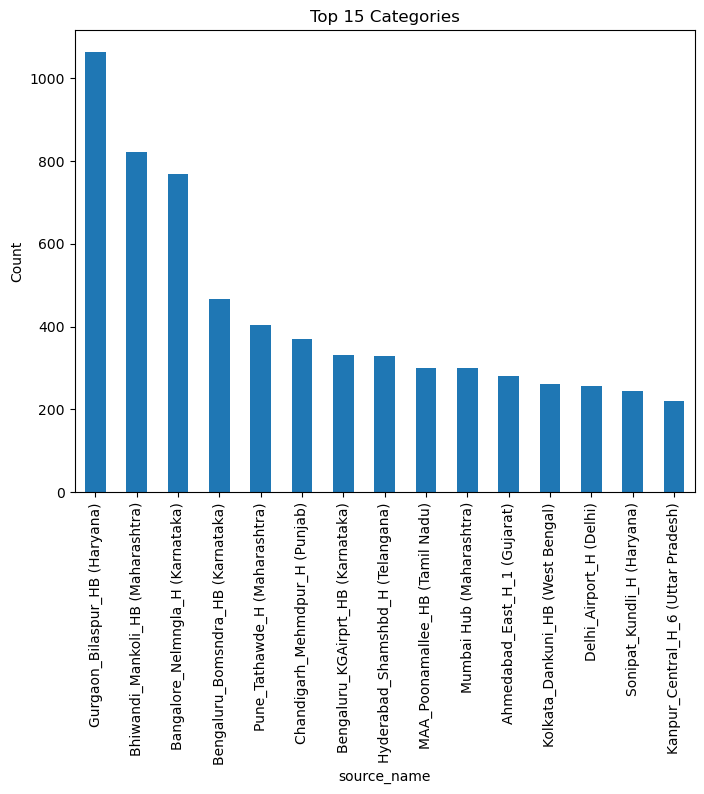

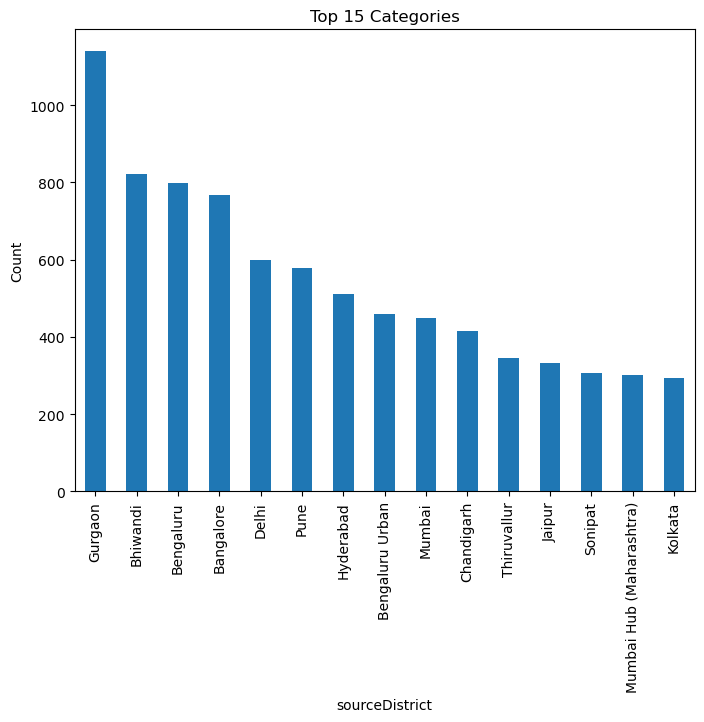

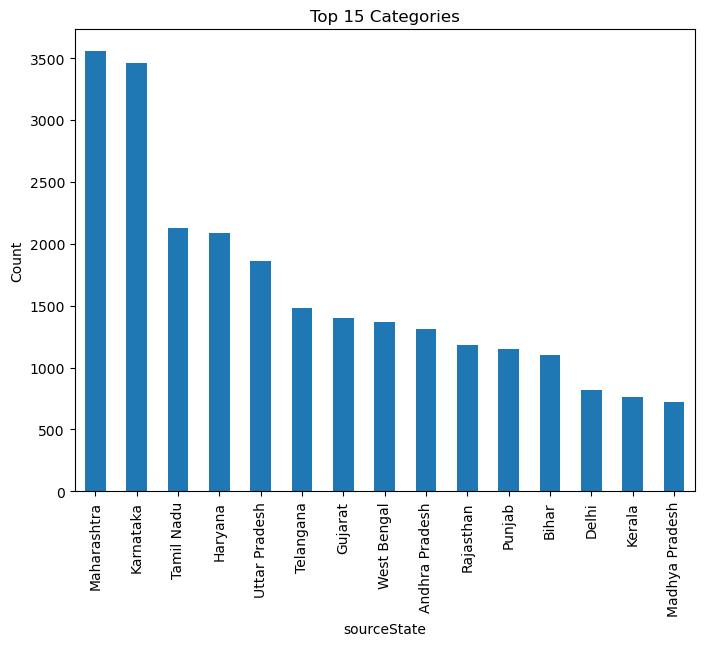

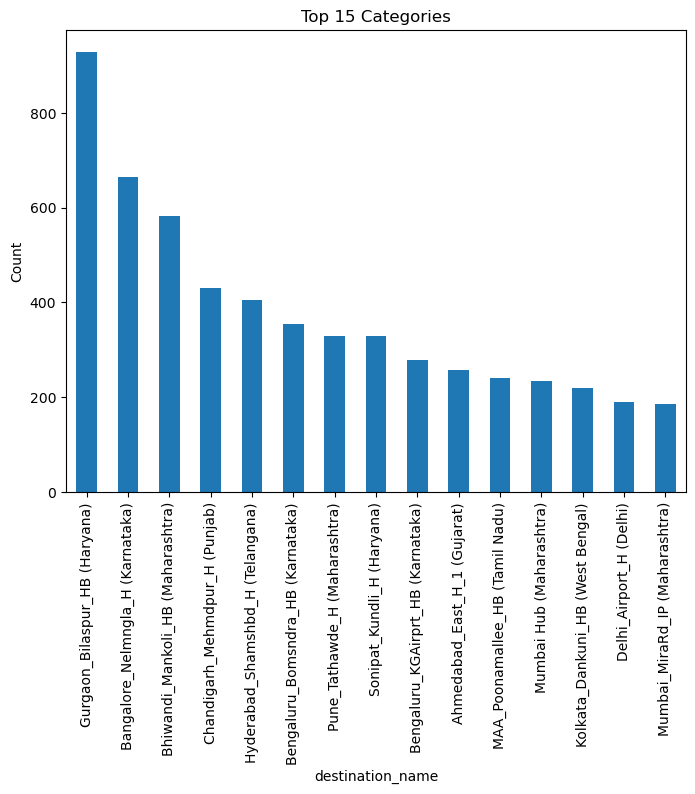

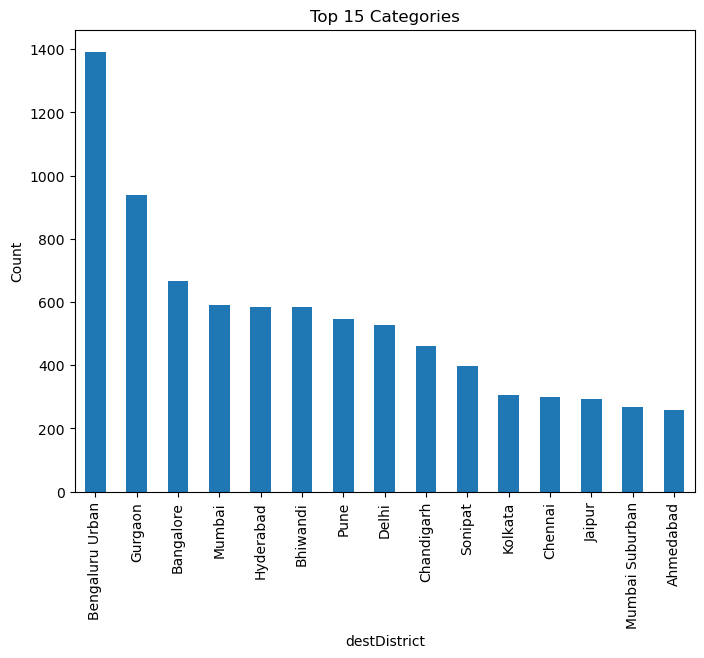

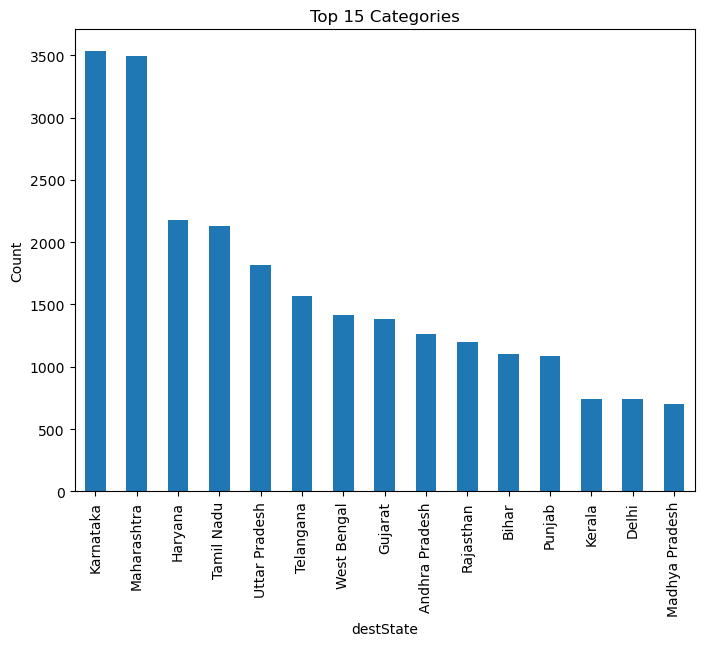

In [1382]:
for i in ['source_name', 'sourceDistrict', 'sourceState','destination_name', 'destDistrict', 'destState']:
    N = 15  # Number of top categories to plot
    top_categories = segment[i].value_counts().nlargest(N)

    # Group other categories into an 'Other' category
    other_count = df[i].value_counts().sum() - top_categories.sum()
    #top_categories['Other'] = other_count

    # Plot value counts
    plt.figure(figsize=(8, 6))
    top_categories.plot(kind='bar')
    plt.title(f'Top {N} Categories')
    plt.xlabel(i)
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.show()

# Gurugram,Bengaluru,maharashtra has highest orders

In [803]:
test = df.groupby(["segment"]).agg({"actual_time":"last",
                            "source_name":"first",
                            "sourceDistrict":"first",
                             "sourceState":"first",
                             "destination_name":"first",
                            "destDistrict":"first",
                             "destState":"first",
                            "sourceLatitude":"first",
                            "sourceLongitude":"first",
                                    "destLatitude":"first",
                                    "destLongitude":"first"
                            }).reset_index()

# more plots and analysis

In [1100]:
tmp = test.groupby(["sourceState"]).agg({"segment":"count"}).reset_index().sort_values(by=["segment"],ascending=False)

In [1101]:
def plotBar(data,x,y):
    fig= plt.figure(figsize=(10,5))
    sns.barplot(data=data, x=x, y=y)
    plt.xticks(rotation=90)

    # Add labels and title
    plt.xlabel('Categories')
    plt.ylabel('Count')
    plt.title('Countplot of Aggregated Data')


    # Show the plot
    plt.show()

# Maharashtra tops for a trip source

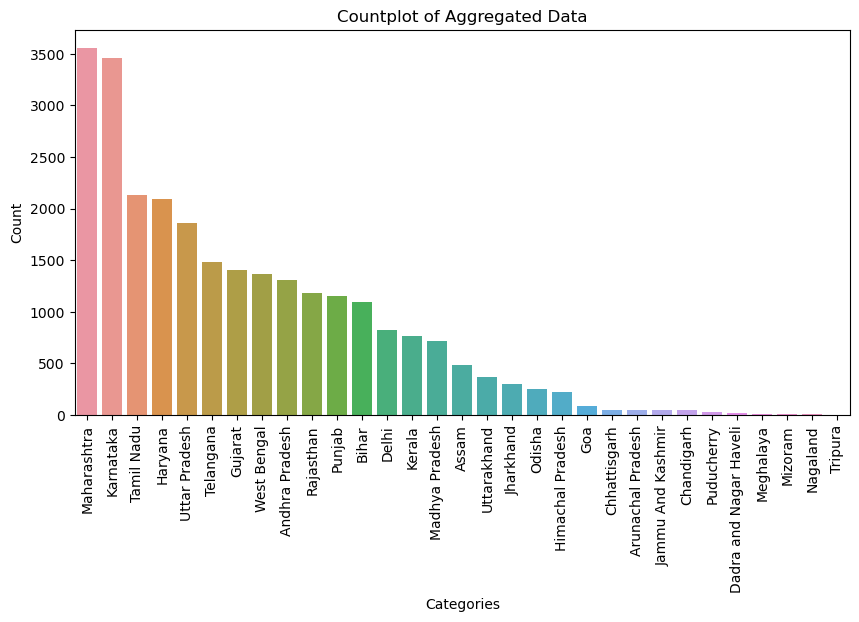

In [1102]:
plotBar(tmp,"sourceState","segment")

<Axes: ylabel='segment'>

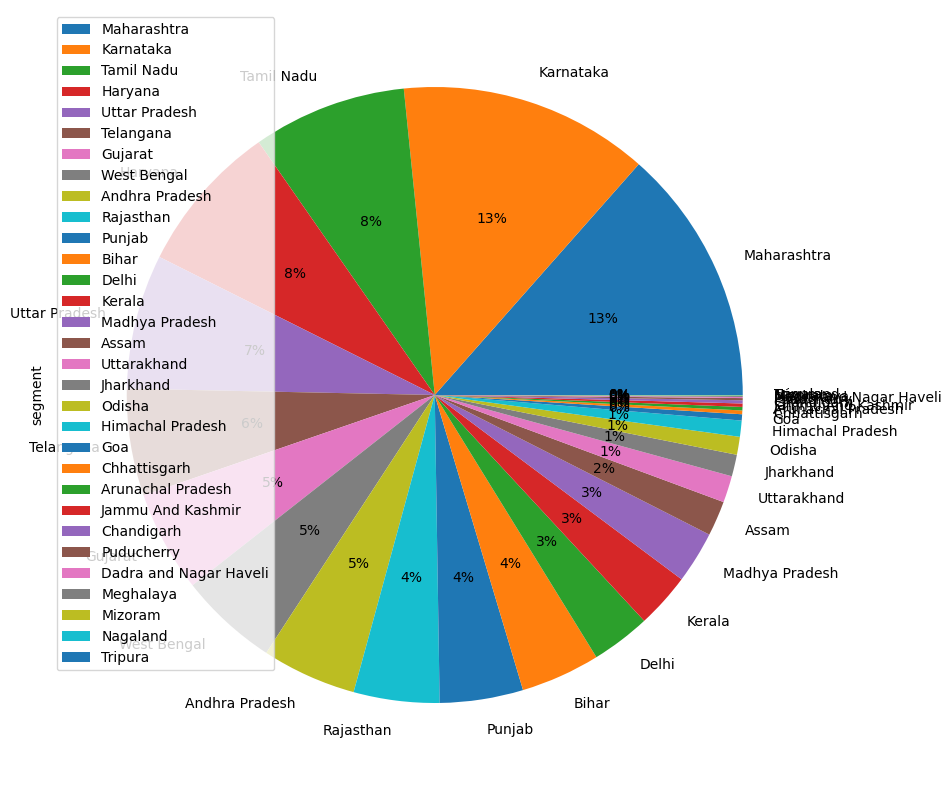

In [1112]:
tmp.index = tmp["sourceState"]
tmp.plot.pie(y='segment', figsize=(10, 10),autopct='%1.0f%%')

In [1113]:
tmp = test.groupby(["destState"]).agg({"segment":"count"}).reset_index().sort_values(by=["segment"],ascending=False)

<Axes: ylabel='segment'>

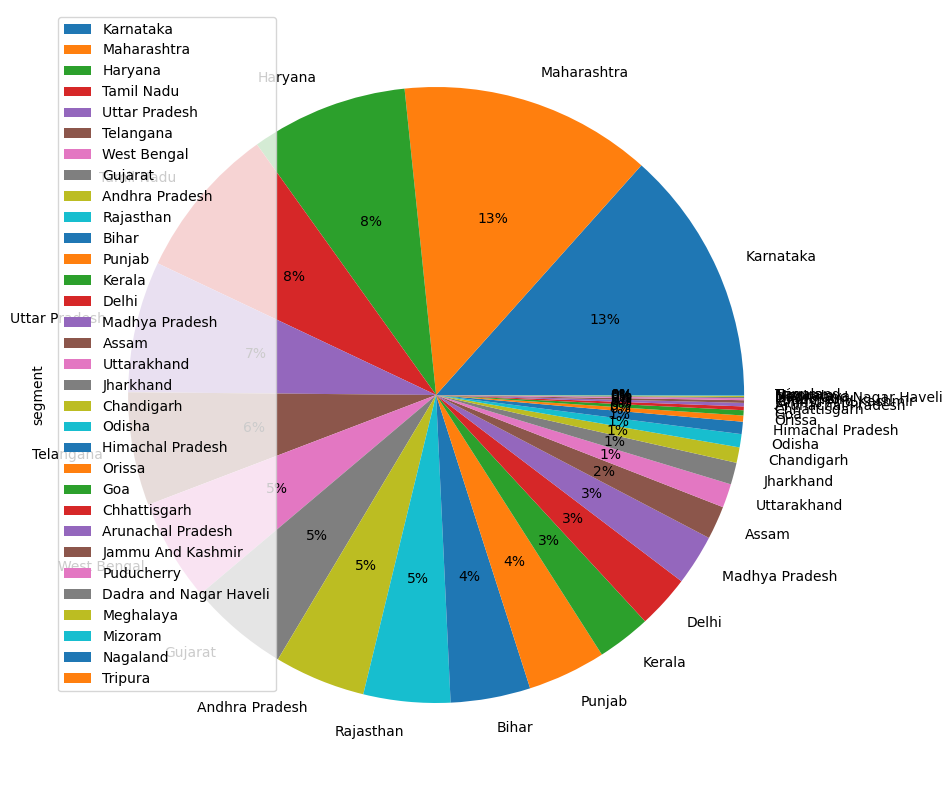

In [1115]:
tmp.index = tmp["destState"]
tmp.plot.pie(y='segment', figsize=(10, 10),autopct='%1.0f%%')

# Karnataka and Maharashtra both joins to be the top destination for a source

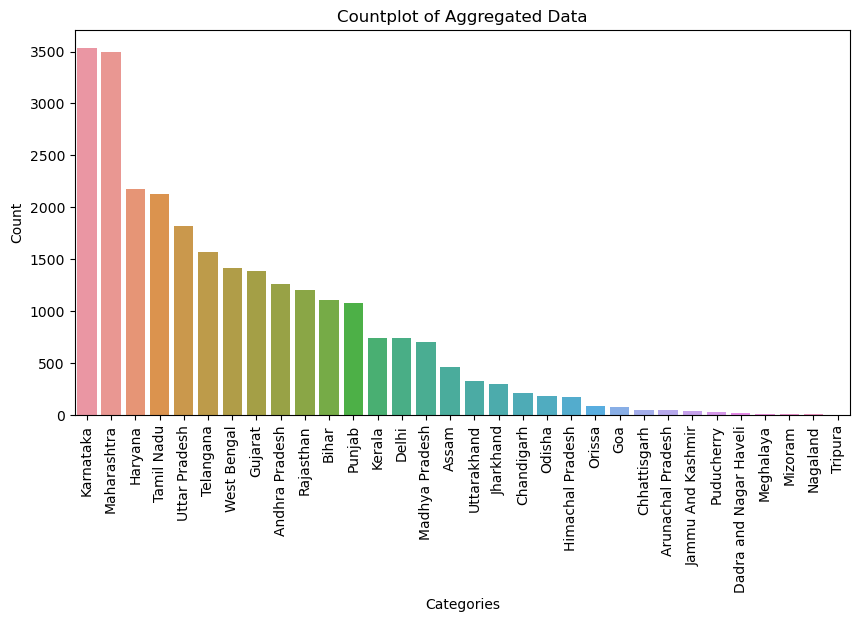

In [982]:
plotBar(tmp,"destState","segment")

# Gurugram came out to be top source City

In [1117]:
tmp = test.groupby(["sourceDistrict"]).agg({"segment":"count"}).reset_index().sort_values(by=["segment"],ascending=False).head(15)

<Axes: ylabel='segment'>

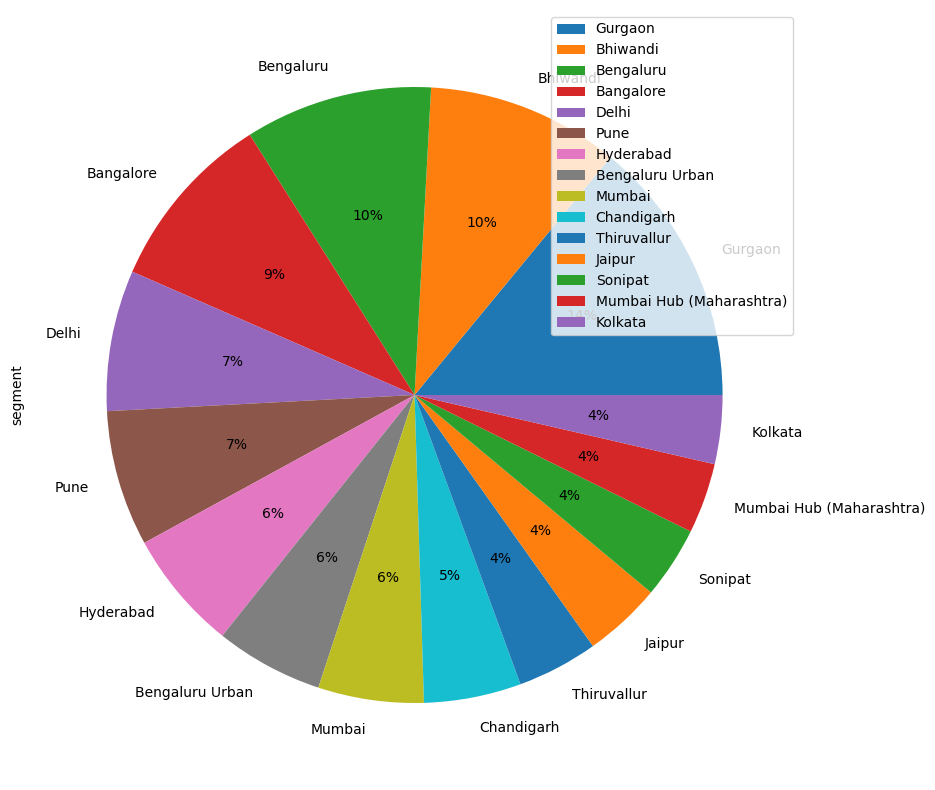

In [1118]:
tmp.index = tmp["sourceDistrict"]
tmp.plot.pie(y='segment', figsize=(10, 10),autopct='%1.0f%%')

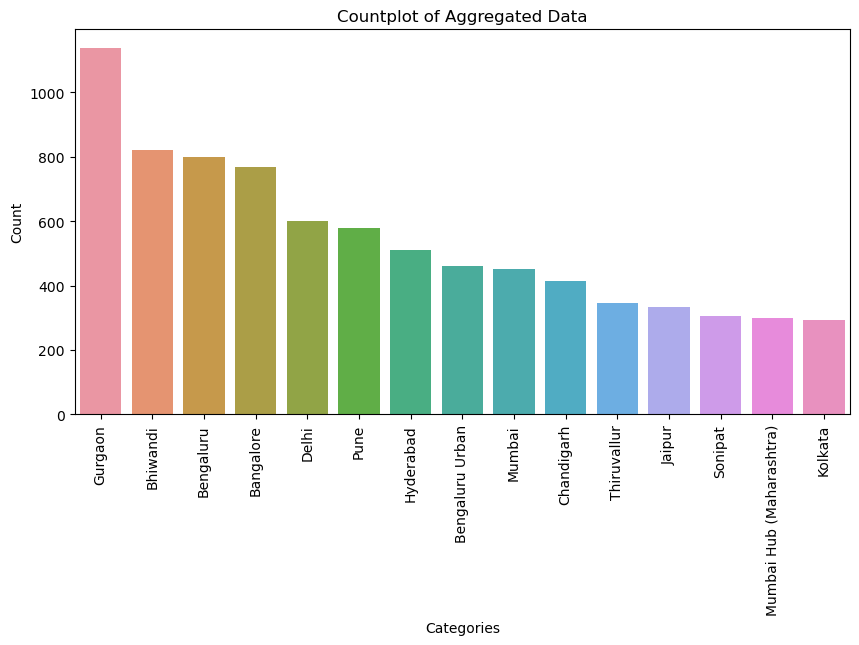

In [986]:
plotBar(tmp,"sourceDistrict","segment")

# Bangalore came out to be top destination city

In [1119]:
tmp = test.groupby(["destDistrict"]).agg({"segment":"count"}).reset_index().sort_values(by=["segment"],ascending=False).head(15)

<Axes: ylabel='segment'>

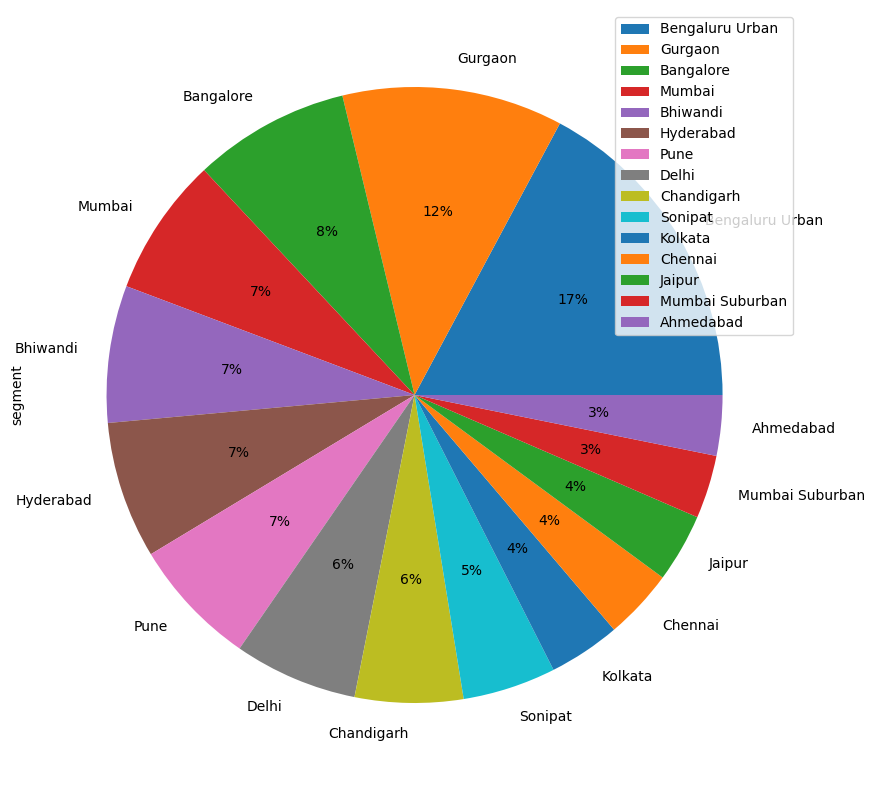

In [1120]:
tmp.index = tmp["destDistrict"]
tmp.plot.pie(y='segment', figsize=(10, 10),autopct='%1.0f%%')

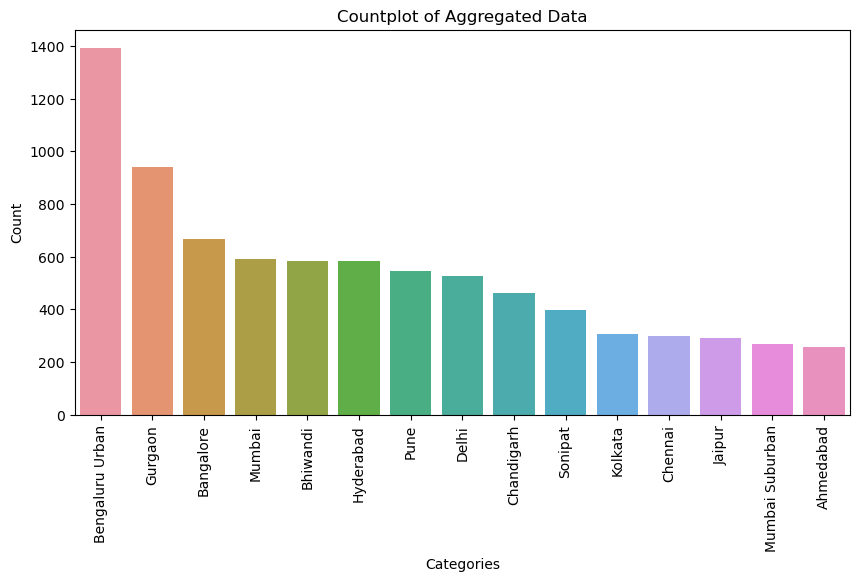

In [989]:
plotBar(tmp,"destDistrict","segment")

In [1124]:
tmp = test.groupby(["sourceState","destState"]).agg({"segment":"count"}).reset_index().sort_values(by=["segment"],ascending=False).head(15)

In [1125]:
tmp["state->state"] = tmp["sourceState"] + "->" +tmp["destState"]

<Axes: ylabel='segment'>

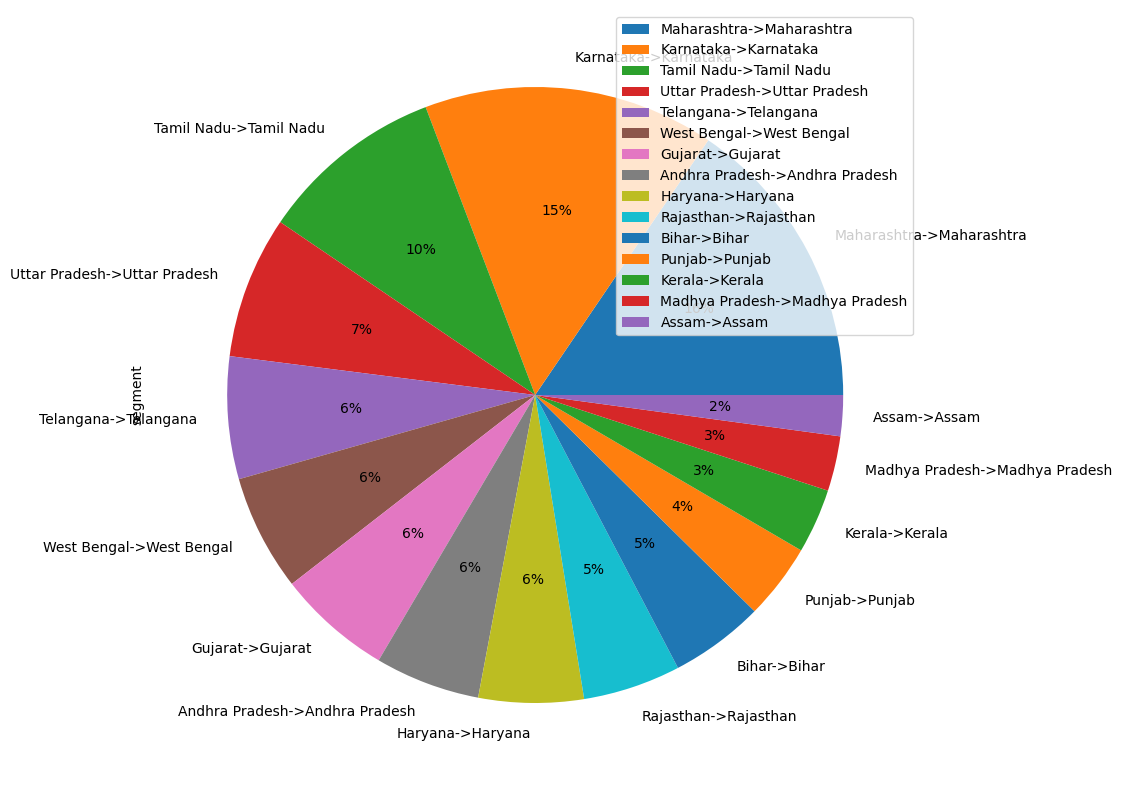

In [1126]:
tmp.index = tmp["state->state"]
tmp.plot.pie(y='segment', figsize=(10, 10),autopct='%1.0f%%')

# Maharashtra to Mahrashtra and Karnataka to Karnataka tops in intra city trips

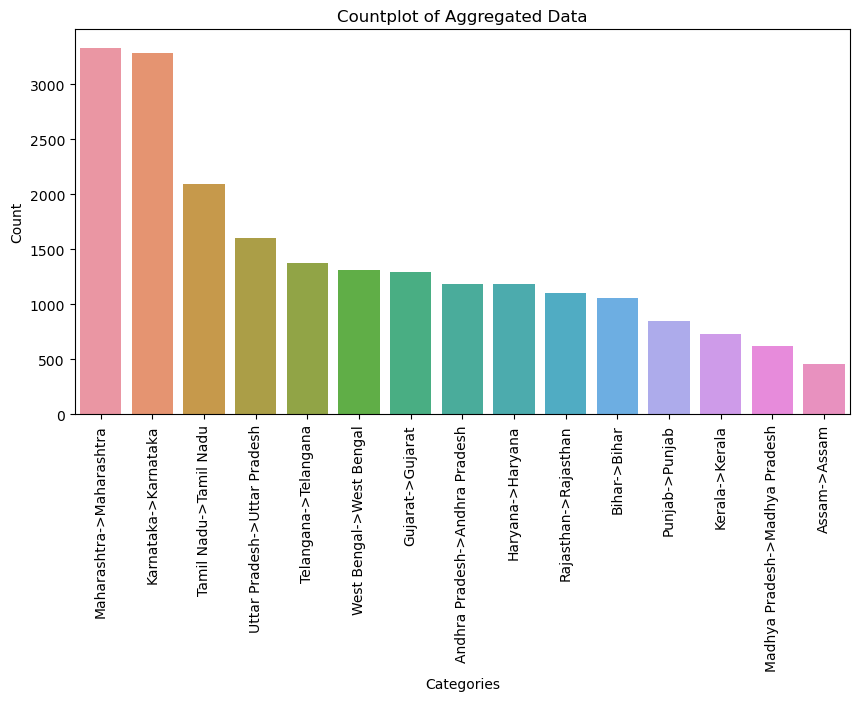

In [998]:
plotBar(tmp,"state->state","segment")

# Visualizing the top routes 

In [1029]:
tmp = (test[(test["sourceDistrict"]!=test["destDistrict"]) & (test["sourceState"]!=test["destState"])].
       groupby(["source_name","destination_name"]).
       agg({"segment":"count",
            "sourceDistrict":"first",
            "destDistrict": "first"}).
       reset_index().
       sort_values(by=["segment"],ascending=False))

tmp.replace('', pd.NA, inplace=True)
# Drop rows with None values
tmp.dropna(inplace=True)

tmp = tmp[["sourceDistrict","destDistrict"]].head(20)
coords_1=[]
for ind in tmp.index:
    coords_1.extend([list(city_coordinates[tmp['sourceDistrict'][ind]]),list(city_coordinates[tmp['destDistrict'][ind]])])

In [1031]:
f1=folium.FeatureGroup("Busiest")
fig5=Figure(height=550,width=750)
m5=folium.Map(location=[12.9716, 77.5946],tiles='cartodbpositron',zoom_start=14)
fig5.add_child(m5)
line_1=folium.vector_layers.PolyLine(coords_1,popup='<b>Path of Vehicle_1</b>',tooltip='Vehicle_1',color='red',weight=1).add_to(f1)
f1.add_to(m5)
folium.LayerControl().add_to(m5)
m5

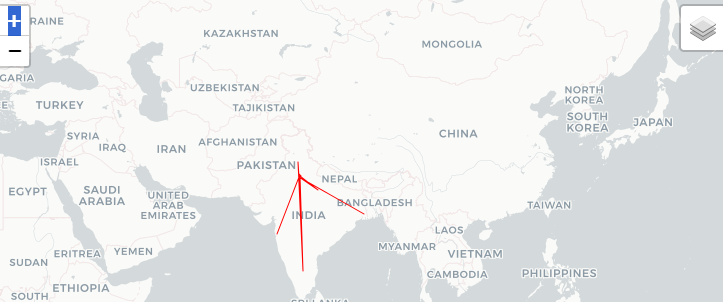

In [852]:
#df['Stream'][ind])
    
# LatLong = set(df["sourceDistrict"].unique()).union(df["destDistrict"].unique())
# from geopy.geocoders import Nominatim

# # Initialize Nominatim geocoder
# geolocator = Nominatim(user_agent="test")

# # Function to get latitude and longitude of a city
# def get_lat_long(city):
#     location = geolocator.geocode(city)
#     if location:
#         return (location.latitude, location.longitude)
#     else:
#         return None

# # Get latitude and longitude for each city
# city_coordinates = {city: get_lat_long(city) for city in LatLong}
# city_coordinates["FBD"] = (28.4089,77.3178)
# city_coordinates["Del"] = city_coordinates["Delhi"]

# Highest distance trip between cities

In [1034]:
test = df.groupby(["segment"]).agg({"segment_osrm_distance":"sum",
                            "source_name":"first",
                            "sourceDistrict":"first",
                             "sourceState":"first",
                             "destination_name":"first",
                            "destDistrict":"first",
                             "destState":"first"
                            }).reset_index()

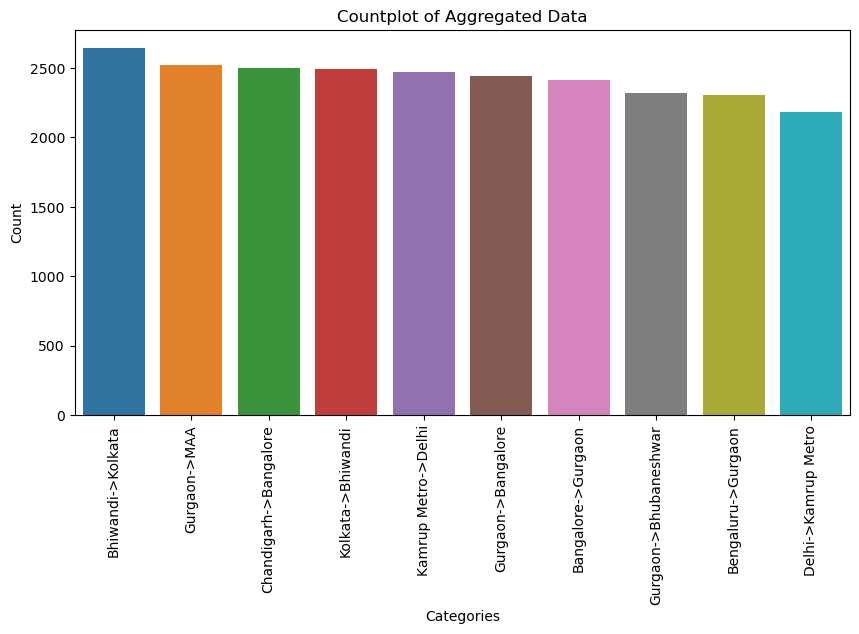

In [1052]:
longDist = (test[["source_name","sourceDistrict","destDistrict","destination_name","segment_osrm_distance"]].
 sort_values(by=["segment_osrm_distance"],ascending=False).
 drop_duplicates(subset=["source_name","sourceDistrict","destDistrict","destination_name"])).head(10)

longDist["source->dest"] = longDist["sourceDistrict"]+"->" +longDist["destDistrict"]
longDist = longDist[["source->dest","segment_osrm_distance"]]

plotBar(longDist,"source->dest","segment_osrm_distance")

# Most time consuming Trip

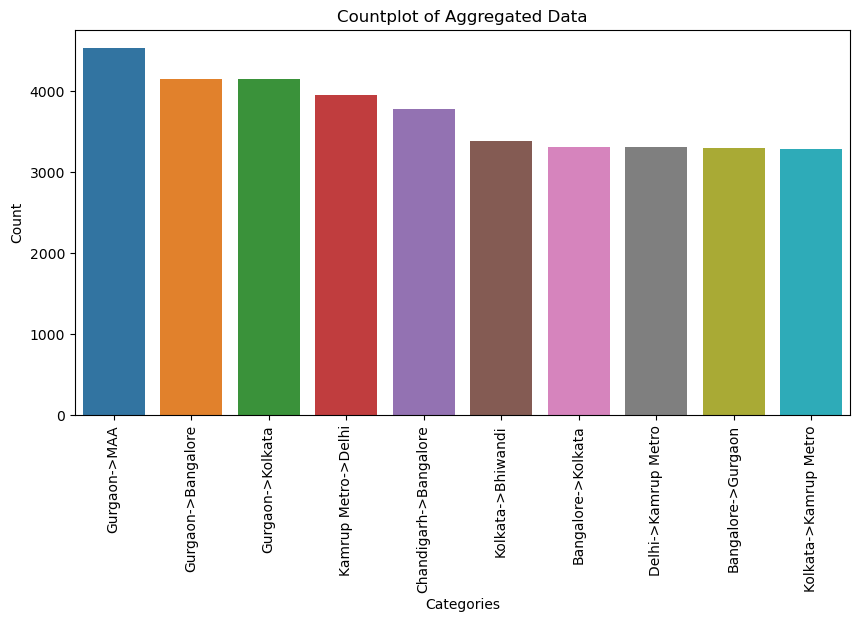

In [1064]:
longTime = (test[["source_name","sourceDistrict","destDistrict","destination_name","actual_time"]].
 sort_values(by=["actual_time"],ascending=False).
 drop_duplicates(subset=["source_name","sourceDistrict","destDistrict","destination_name"])).head(10)

longTime["source->dest"] = longTime["sourceDistrict"]+"->" +longTime["destDistrict"]

longTime = longTime[["source->dest","actual_time"]]

plotBar(longTime,"source->dest","actual_time")

# Q Busiest source to destination city route

<Axes: ylabel='segment'>

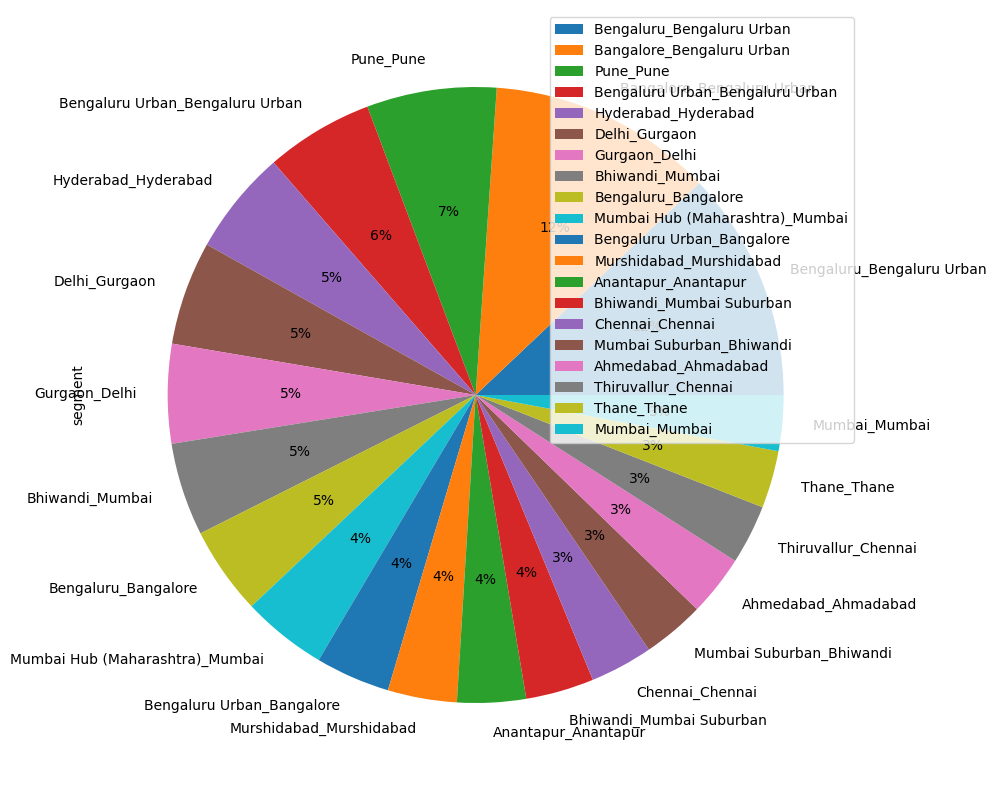

In [1507]:
tmp = segment.groupby(["sourceDistrict","destDistrict"]).agg({"segment":"count"}).reset_index().sort_values(by=["segment"],ascending=False).head(20)
tmp.index = tmp["sourceDistrict"] + "_"+tmp["destDistrict"]
tmp.plot.pie(y='segment', figsize=(10, 10),autopct='%1.0f%%')

# Q which is the most busiest city in each state

<Axes: ylabel='segment'>

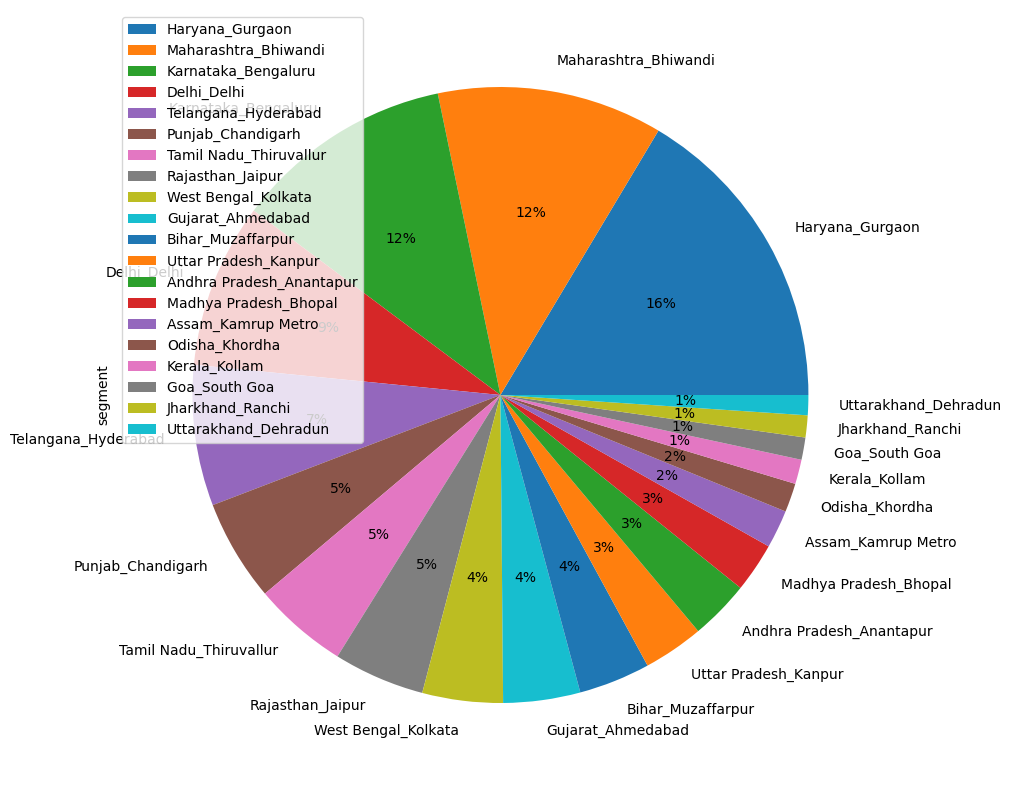

In [1490]:
tmp = segment.groupby(["sourceState","sourceDistrict"]).agg({"segment":"count"}).reset_index()
tmp2 = tmp.groupby(["sourceState"]).agg({"segment":"max"}).reset_index().merge(tmp,on=["sourceState","segment"]).sort_values(by=["segment"],ascending=False)[["sourceState","sourceDistrict","segment"]].head(20)
tmp2.index = tmp2["sourceState"] + "_"+tmp2["sourceDistrict"]
tmp2.plot.pie(y='segment', figsize=(10, 10),autopct='%1.0f%%')

# Q : Route with high AVG time

In [1530]:
tmp = segment[segment["sourceState"]!=segment["destState"]]
tmp = tmp.groupby(["source_name","destination_name"]).agg({"actual_time":"mean","segment_osrm_distance":"mean"}).reset_index().sort_values(by=["segment_osrm_distance","actual_time"],ascending=[True,False])
tmp[(tmp["actual_time"]>100) & (tmp["segment_osrm_distance"]<100)].sort_values(by=["actual_time"],ascending=False).head(20)

source_name  \
72           Chandigarh_Panchkula (Chandigarh)   
240            Sidhmukh_MnbzrDPP_D (Rajasthan)   
100                  Delhi_Mayapuri_PC (Delhi)   
105                   Delhi_Rohini_DPC (Delhi)   
151              Gurgaon_Bilaspur_HB (Haryana)   
214  Nalagarh_Central_DPP_2 (Himachal Pradesh)   
68              Chandigarh_Mehmdpur_H (Punjab)   
182          JoguGadwal_ColctrOf_D (Telangana)   
101                    Delhi_Nangli_IP (Delhi)   
212                            NOI_RPC (Delhi)   
99                Delhi_Kishangarh_DPC (Delhi)   
129              Gurgaon_Bilaspur_HB (Haryana)   
211               Moradabad_DC (Uttar Pradesh)   
13          Baddi_ByePass_D (Himachal Pradesh)   
159              Gurgaon_Bilaspur_RP (Haryana)   
110               Dholpur_GtRoad_D (Rajasthan)   
209                     Meerut (Uttar Pradesh)   
104                   Delhi_PunjabiB_L (Delhi)   
75           Chhata_GvrdnDPP_D (Uttar Pradesh)   
103               Delhi_Patparganj_DPC (Delhi)   

                        destination_name  actual_time  segment_osrm_distance  
72        Chandigarh_Mehmdpur_H (Punjab)   436.400000              35.691973  
240           Hisar_ModelTwn_P (Haryana)   351.000000              71.905400  
100        Gurgaon_Bilaspur_HB (Haryana)   349.846154              64.217797  
105        Gurgaon_Bilaspur_HB (Haryana)   215.428571              71.992371  
151      Neemrana_Rcocmplx_D (Rajasthan)   210.000000              62.922600  
214       Chandigarh_Mehmdpur_H (Punjab)   194.454545              86.265445  
68   Solan_MohanPrk_D (Himachal Pradesh)   191.055556              97.688517  
182  Kurnool_AbbasNgr_I (Andhra Pradesh)   190.000000              83.538400  
101        Gurgaon_Bilaspur_HB (Haryana)   188.600000              47.231060  
212              Delhi_Airport_H (Delhi)   188.500000              36.037050  
99         Gurgaon_Bilaspur_HB (Haryana)   187.571429              54.701414  
129              Delhi_Jhilmil_L (Delhi)   183.055556              90.529092  
211    Rudrapur_UdhamNgr_H (Uttarakhand)   180.125000              97.554694  
13        Chandigarh_Mehmdpur_H (Punjab)   177.666667              69.132483  
159                    Del_B_RPC (Delhi)   175.363636              50.947927  
110                 Agra_(Uttar Pradesh)   172.714286              61.663400  
209           Sonipat_Kundli_H (Haryana)   164.200000              81.035320  
104        Gurgaon_Bilaspur_HB (Haryana)   156.529412              66.191518  
75          FBD_Balabhgarh_DPC (Haryana)   153.666667              93.016667  
103        Gurgaon_Bilaspur_HB (Haryana)   146.166667              75.052200

# Fastest Routes

In [1533]:
tmp = segment[segment["sourceState"]!=segment["destState"]]
tmp = tmp.groupby(["source_name","destination_name"]).agg({"actual_time":"mean","segment_osrm_distance":"mean"}).reset_index().sort_values(by=["segment_osrm_distance","actual_time"],ascending=[True,False])
tmp[(tmp["actual_time"]<400) & (tmp["segment_osrm_distance"]>200)].sort_values(by=["actual_time"],ascending=False).head(20)

source_name  \
108         Dhanbad_Kalynpur_I (Jharkhand)   
6             Ahmedabad_East_H_1 (Gujarat)   
94                Delhi_Gateway_HB (Delhi)   
256       Vellore_GndhiNgr_IP (Tamil Nadu)   
175                 Jaipur_Hub (Rajasthan)   
3             Agra_Idgah_P (Uttar Pradesh)   
140          Gurgaon_Bilaspur_HB (Haryana)   
59          Chandigarh_Mehmdpur_H (Punjab)   
145          Gurgaon_Bilaspur_HB (Haryana)   
176                 Jaipur_Hub (Rajasthan)   
177             Jaipur_RIICO_L (Rajasthan)   
11   Anantapur_KamaStrt_I (Andhra Pradesh)   
111           Dholpur_GtRoad_D (Rajasthan)   
146          Gurgaon_Bilaspur_HB (Haryana)   
52          Chandigarh_Mehmdpur_H (Punjab)   
83                 Delhi_Airport_H (Delhi)   
9           Ambur_Central_D_2 (Tamil Nadu)   
2             Agra_Idgah_L (Uttar Pradesh)   
0                     Agra_(Uttar Pradesh)   
4             Agra_Idgah_P (Uttar Pradesh)   

                        destination_name  actual_time  segment_osrm_distance  
108          Sasaram_Central_I_2 (Bihar)   395.000000             414.389000  
6           Udaipur_Mangri_I (Rajasthan)   392.571429             284.763407  
94        Chandigarh_Mehmdpur_H (Punjab)   386.619048             236.640676  
256     Bangalore_Nelmngla_H (Karnataka)   369.000000             245.243350  
175              Delhi_Airport_H (Delhi)   366.928571             297.217221  
3                Delhi_Airport_H (Delhi)   364.285714             297.248557  
140         Dholpur_GtRoad_D (Rajasthan)   360.800000             264.278860  
59               Delhi_Airport_H (Delhi)   338.111111             235.153667  
145               Jaipur_Hub (Rajasthan)   317.000000             239.277770  
176        Gurgaon_Bilaspur_HB (Haryana)   315.173913             248.193287  
177        Gurgaon_Bilaspur_HB (Haryana)   313.000000             264.620414  
11      Bangalore_Nelmngla_H (Karnataka)   312.375000             226.211750  
111        Gurgaon_Bilaspur_HB (Haryana)   305.000000             332.991700  
146           Jaipur_RIICO_L (Rajasthan)   304.700000             243.368025  
52   Bhota_BpassDPP_D (Himachal Pradesh)   298.500000             214.768900  
83                  Agra_(Uttar Pradesh)   297.000000             204.635200  
9       Bangalore_Nelmngla_H (Karnataka)   291.333333             201.544317  
2          Gurgaon_Bilaspur_HB (Haryana)   291.000000             294.249500  
0                Delhi_Airport_H (Delhi)   291.000000             254.696300  
4          Gurgaon_Bilaspur_HB (Haryana)   289.000000             317.806600

# Distribution of all Numerical Features

In [1136]:
segment = (df.groupby(["segment"]).
             agg({"source_name":"first",
            "sourceDistrict":"first",
            "sourceState":"first",
            "destination_name":"first",
            "destDistrict":"first",
            "destState":"first",
            "start_scan_to_end_scan":"first",
            "actual_time":"last",
            "osrm_time":"last",
            "osrm_distance":"last",
            "segment_actual_time":"sum",
            "segment_osrm_time":"sum",
            "segment_osrm_distance":"sum",
                 "trip_time_inhr":"last"}).
             reset_index())

C:\Users\akash\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



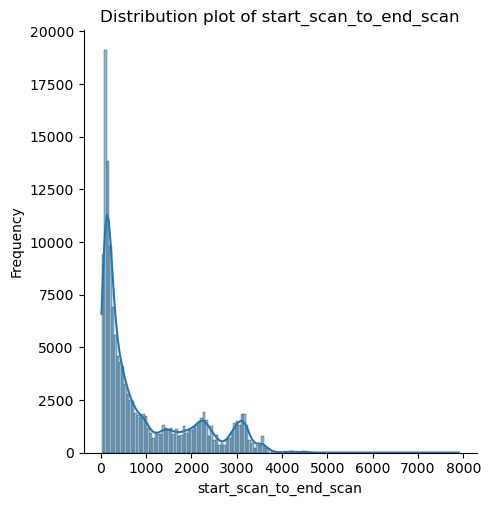

C:\Users\akash\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



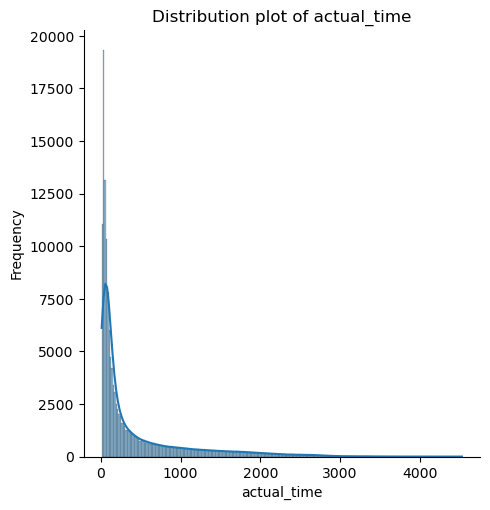

C:\Users\akash\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



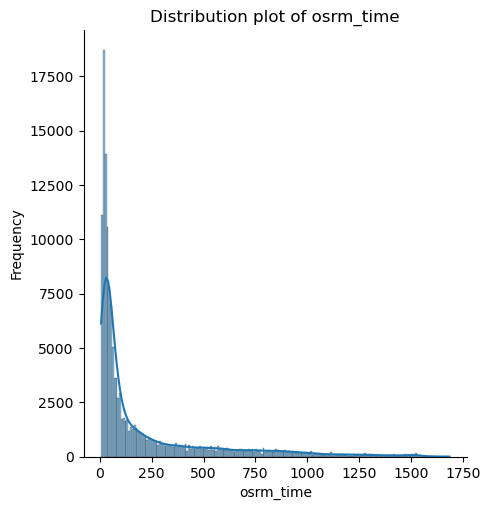

C:\Users\akash\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



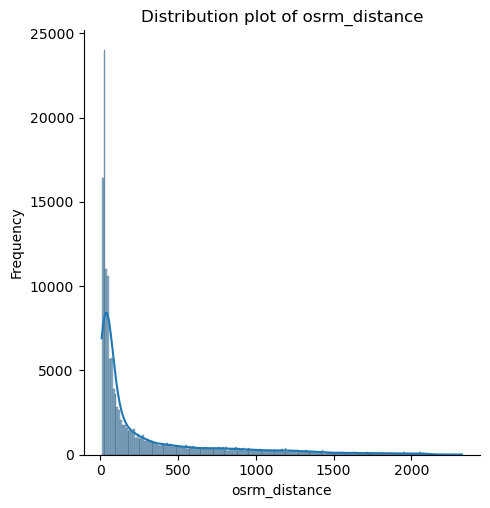

C:\Users\akash\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



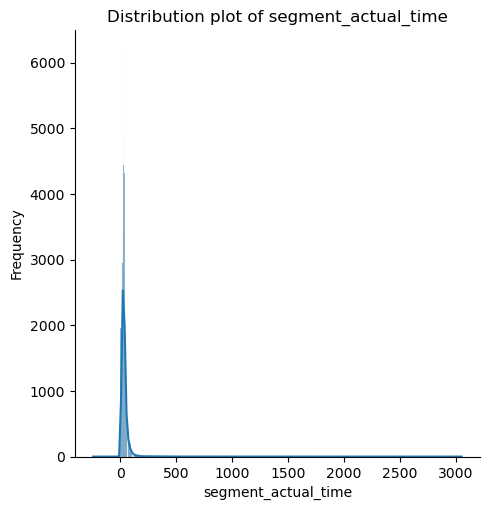

C:\Users\akash\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



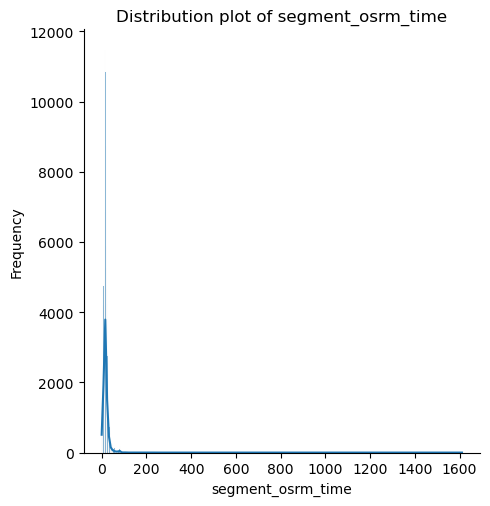

C:\Users\akash\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



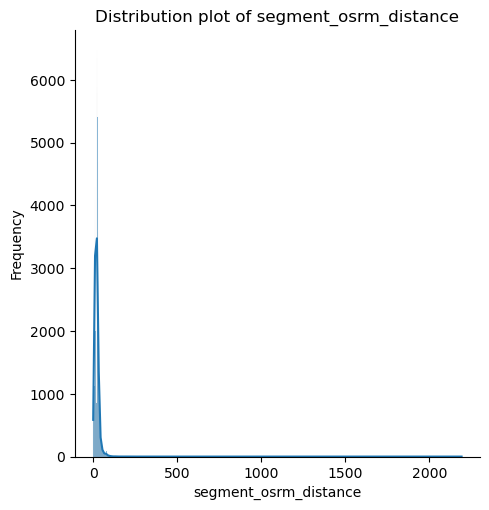

C:\Users\akash\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



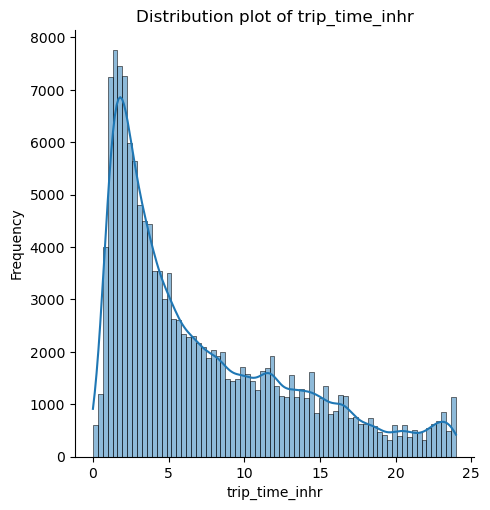

In [1147]:
for column in segment.select_dtypes(include='number'):
    # Create distribution plot
    sns.displot(df[column], kde=True)  # Adjust 'kde' and 'bins' as needed
    
    # Add labels and title
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Distribution plot of {column}')
    
    # Show the plot
    plt.show()

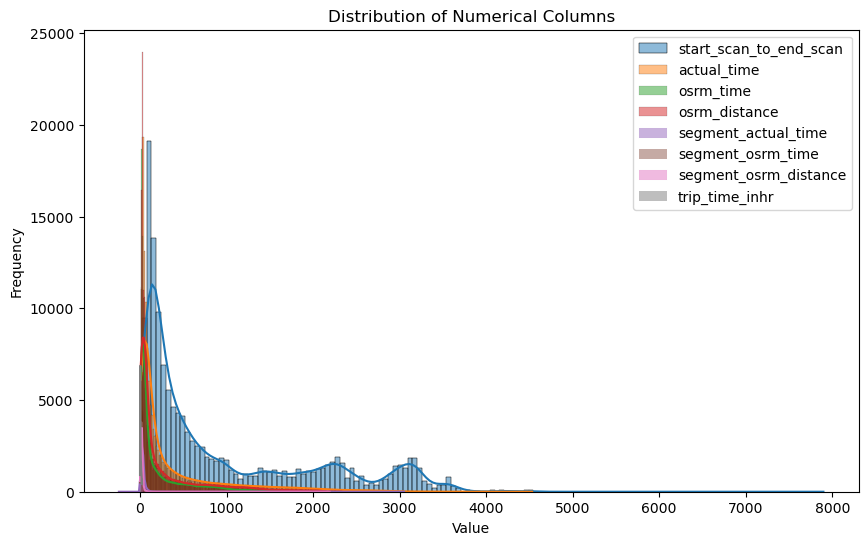

In [1146]:
# Create the distribution plot
plt.figure(figsize=(10, 6))
for column in segment.select_dtypes(include='number'):
    sns.histplot(df[column], kde=True, label=column)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Numerical Columns')
plt.legend()

# Show the plot
plt.show()

1. All the continuos variable looks like right tail distrribution
2. They are definetly not gaussian.

# One Hot Encoding on categorical data

In [1345]:
df_lower = segment.applymap(lambda x: x.lower() if isinstance(x, str) else x)

for i in ['source_name', 'route_type', 'sourceDistrict', 'sourceState','destination_name', 'destDistrict', 'destState']:
    one_hot_encoded = pd.get_dummies(df_lower[i],prefix='Category')
    one_hot_encoded = one_hot_encoded.astype(int)
    df_lower = pd.concat([df_lower.drop(i, axis=1), one_hot_encoded], axis=1)

In [1363]:
df_lower.head()

segment  start_scan_to_end_scan  \
0  trip-153671041653548748bhopal_trnsport_h (madh...                   999.0   
1  trip-153671041653548748kanpur_central_h_6 (utt...                  1260.0   
2  trip-153671042288605164doddablpur_chikadpp_d (...                    58.0   
3  trip-153671042288605164tumkur_veersagr_i (karn...                   122.0   
4  trip-153671043369099517bangalore_nelmngla_h (k...                  3099.0   

   actual_time  osrm_time  osrm_distance  segment_actual_time  \
0        830.0      388.0       544.8027                820.0   
1        732.0      329.0       446.5496                728.0   
2         47.0       26.0        28.1994                 46.0   
3         96.0       42.0        56.9116                 95.0   
4       2736.0     1528.0      2072.8556               2700.0   

   segment_osrm_time  segment_osrm_distance  trip_time_inhr  \
0              474.0               649.8528       16.650000   
1              534.0               670.6205       21.000000   
2               26.0                28.1995        0.966667   
3               39.0                55.9899        2.033333   
4             1710.0              2227.5270        3.650000   

   Category_abohar_dc (punjab)  ...  Category_orissa  Category_puducherry  \
0                            0  ...                0                    0   
1                            0  ...                0                    0   
2                            0  ...                0                    0   
3                            0  ...                0                    0   
4                            0  ...                0                    0   

   Category_punjab  Category_rajasthan  Category_tamil nadu  \
0                0                   0                    0   
1                0                   0                    0   
2                0                   0                    0   
3                0                   0                    0   
4                0                   0                    0   

   Category_telangana  Category_tripura  Category_uttar pradesh  \
0                   0                 0                       1   
1                   0                 0                       0   
2                   0                 0                       0   
3                   0                 0                       0   
4                   0                 0                       0   

   Category_uttarakhand  Category_west bengal  
0                     0                     0  
1                     0                     0  
2                     0                     0  
3                     0                     0  
4                     0                     0  

[5 rows x 4217 columns]

# Numeric Data

In [1360]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = MinMaxScaler()
std = StandardScaler()
dfNormalize = pd.DataFrame(scaler.fit_transform(df_lower[df_lower.columns[1:9]]),columns=df_lower.columns[1:9])
df_std = pd.DataFrame(std.fit_transform(df_lower[df_lower.columns[1:9]]),columns=df_lower.columns[1:9])

In [1361]:
dfNormalize.head()

start_scan_to_end_scan  actual_time  osrm_time  osrm_distance  \
0                0.124270     0.181517   0.227381       0.231204   
1                0.157400     0.159850   0.192262       0.188801   
2                0.004824     0.008402   0.011905       0.008254   
3                0.012947     0.019235   0.021429       0.020646   
4                0.390835     0.602918   0.905952       0.890665   

   segment_actual_time  segment_osrm_time  segment_osrm_distance  \
0             0.180423           0.242236               0.243471   
1             0.159956           0.273292               0.251362   
2             0.008231           0.010352               0.007267   
3             0.019132           0.017081               0.017827   
4             0.598665           0.881988               0.842925   

   trip_time_inhr  
0        0.694232  
1        0.875608  
2        0.040306  
3        0.084781  
4        0.152189

In [1362]:
df_std.head()

start_scan_to_end_scan  actual_time  osrm_time  osrm_distance  \
0                1.590549     1.635224   1.606431       1.694356   
1                2.182986     1.380576   1.287645       1.307181   
2               -0.545402    -0.399355  -0.349513      -0.341367   
3               -0.400130    -0.272031  -0.263062      -0.228224   
4                6.357282     6.587850   7.766032       7.715790   

   segment_actual_time  segment_osrm_time  segment_osrm_distance  \
0             1.629100           1.726520               1.834136   
1             1.387805           2.004753               1.906768   
2            -0.400925          -0.350950              -0.340031   
3            -0.272409          -0.290667              -0.242837   
4             6.559912           7.458113               7.351885   

   trip_time_inhr  
0        3.089988  
1        4.158848  
2       -0.763639  
3       -0.501543  
4       -0.104304

# Merging all

In [1368]:
mergedDf = pd.concat([df_lower,df_std],axis=1)

In [1369]:
mergedDf.shape

(26368, 4225)

In [ ]:
# 1. Perform hypothesis testing / visual analysis between :
# a. actual_time aggregated value and OSRM time aggregated value.
# b. actual_time aggregated value and segment actual time aggregated
# value.
# c. OSRM distance aggregated value and segment OSRM distance
# aggregated value.
# d. OSRM time aggregated value and segment OSRM time aggregated
# value.

In [287]:
actual_time = (df.
                groupby(["segment"])["actual_time"].
                last().
                reset_index())

segment_actual_time = (df.
                        groupby(["segment"])["segment_actual_time"].
                        sum().
                        reset_index())
osrm_time = (df.
            groupby(["segment"])["osrm_time"].
            last().
            reset_index())

osrm_distance = (df.
            groupby(["segment"])["osrm_distance"].
            last().
            reset_index())

segment_osrm_distance = (df.
                    groupby(["segment"])["segment_osrm_distance"].
                    sum().
                    reset_index())


segment_osrm_time = (df.
                    groupby(["segment"])["segment_osrm_time"].
                    sum().
                    reset_index())

mergedDf = (actual_time.
            merge(segment_actual_time,on=["segment"]).
            merge(osrm_time,on=["segment"]).
            merge(osrm_distance,on=["segment"]).
            merge(segment_osrm_distance,on=["segment"]).
            merge(segment_osrm_time,on=["segment"]).
            filter(["segment","source_name","destination_name","segment_osrm_distance","osrm_distance","actual_time","segment_actual_time","osrm_time","segment_osrm_time"]))

# Hypothesis Testing 

# 1. Actual time vs OSRM time

### Null hypothesis: mean of actual time  = mean of osmr time

### Alernate hypothesis: mean of actual time is greater than osmr time

### Lets see the mean of them

In [1370]:
print("mean of actual time:",segment["actual_time"].mean())
print("mean of osrm time:",segment["osrm_time"].mean())

mean of actual time: 200.690192657767
mean of osrm time: 90.68670358009709


### We need to figure out is this diference statistically significant or not

### We will use 2 sample ttest here. Also lets consider the singnificance level of 0.05 .

In [1372]:
tstat,pValue = ttest_ind(segment["actual_time"],segment["osrm_time"],alternative = "greater")

alpha = 0.05
print("tstat Value : ",tstat)
print("pValue:",pValue)
if pValue<0.05:
    print("We reject the Null hypothesis claim that the means are equal")
    print("The mean of actual time is greater than that of osmr_time")
else:
    print("We reject the alternate hypothesis that the mean of actual time is grater than osmr time")
    print("The mean of actual time is equal to mean of osmr time")

tstat Value :  41.82845508363711
pValue: 0.0
We reject the Null hypothesis claim that the means are equal
The mean of actual time is greater than that of osmr_time


# 2. actual time vs segment_Actual time

## Null hypothesis:  mean of segment time  = mean of actual time

## mean of actual time is greater than osmr time

In [1374]:
#H0: mean of segment time  = mean of actual time
#ha: mean of actual time is greater than osmr time

print("mean of actual time:",segment["actual_time"].mean())
print("mean of segment_actual_time:",segment["segment_actual_time"].mean())


tstat,pValue= ttest_ind(segment["actual_time"],segment["segment_actual_time"],alternative = "greater")
alpha = 0.05
print("tstat Value : ",tstat)
print("pValue:",pValue)
if pValue<0.05:
    print("We reject the Null hypothesis claim that the means are equal")
    print("The mean of actual time is greater than that of segment_actual_time")
else:
    print("We reject the alternate hypothesis that the mean of actual time is grater than segment_actual_time")
    print("Accepting the Null hypothesis")
    print("The mean of actual time is equal to mean of segment_actual_time")

mean of actual time: 200.690192657767
mean of segment_actual_time: 198.8630916262136
tstat Value :  0.5476525068970126
pValue: 0.29196642323989663
We reject the alternate hypothesis that the mean of actual time is grater than segment_actual_time
Accepting the Null hypothesis
The mean of actual time is equal to mean of segment_actual_time


# 3. osmr time vs segment_osmr_time

## NUll hypothesis: mean of  osrm_time  = mean of segment_osrm_time

## Alternate hypothesis: mean of segment_osrm_time is greater than osrm_time

In [1375]:
#H0: mean of  osrm_time  = mean of segment_osrm_time
#ha: mean of segment_osrm_time is greater than osrm_time


print("mean of osrm_time:",segment["osrm_time"].mean())
print("mean of segment_osrm_time:",segment["segment_osrm_time"].mean())


tstat,pValue= ttest_ind(segment["segment_osrm_time"],segment["osrm_time"],alternative = "greater")
alpha = 0.05
print("tstat Value : ",tstat)
print("pValue:",pValue)
if pValue<0.05:
    print("We reject the Null hypothesis claim that the means are equal")
    print("The mean of segment_osrm_time is greater than that of osrm_time")
else:
    print("We reject the alternate hypothesis that the mean of segment_osrm_time is grater than osrm_time")
    print("Accepting the Null hypothesis")
    print("The mean of segment_osrm_time is equal to mean of osrm_time")


mean of osrm_time: 90.68670358009709
mean of segment_osrm_time: 101.6813182645631
tstat Value :  6.282322100204656
pValue: 1.680741563482449e-10
We reject the Null hypothesis claim that the means are equal
The mean of segment_osrm_time is greater than that of osrm_time
90.68670358009709
101.6813182645631
6.282322100204656 1.680741563482449e-10
Reject h0


# 4. segment_osrm_distance vs osrm distance

## Null hypothesis:  mean of  segment_osrm_distance  = mean of osrm_distance

## Alternate hypothesis:  mean of segment_osrm_time is greater than osrm_time2

In [1380]:
#H0: mean of  segment_osrm_distance  = mean of osrm_distance
#ha: mean of segment_osrm_time is greater than osrm_time


print("mean of segment_osrm_distance:",segment["segment_osrm_distance"].mean())
print("mean of osrm_distance:",segment["osrm_distance"].mean())


tstat,pValue= ttest_ind(segment["segment_osrm_distance"],segment["osrm_distance"],alternative = "greater")
alpha = 0.05
print("tstat Value : ",tstat)
print("pValue:",pValue)
if pValue<0.05:
    print("We reject the Null hypothesis claim that the means are equal")
    print("The mean of segment_osrm_distance is greater than that of osrm_distance")
else:
    print("We reject the alternate hypothesis that the mean of segment_osrm_distance is grater than osrm_distance")
    print("Accepting the Null hypothesis")
    print("The mean of segment_osrm_distance is equal to mean of osrm_distance")

mean of segment_osrm_distance: 125.42368047633497
mean of osrm_distance: 114.82764181962986
tstat Value :  4.500595853737753
pValue: 3.3953972036224005e-06
We reject the Null hypothesis claim that the means are equal
The mean of segment_osrm_distance is greater than that of osrm_distance


# Analysis of trips which looks to be complete round trip

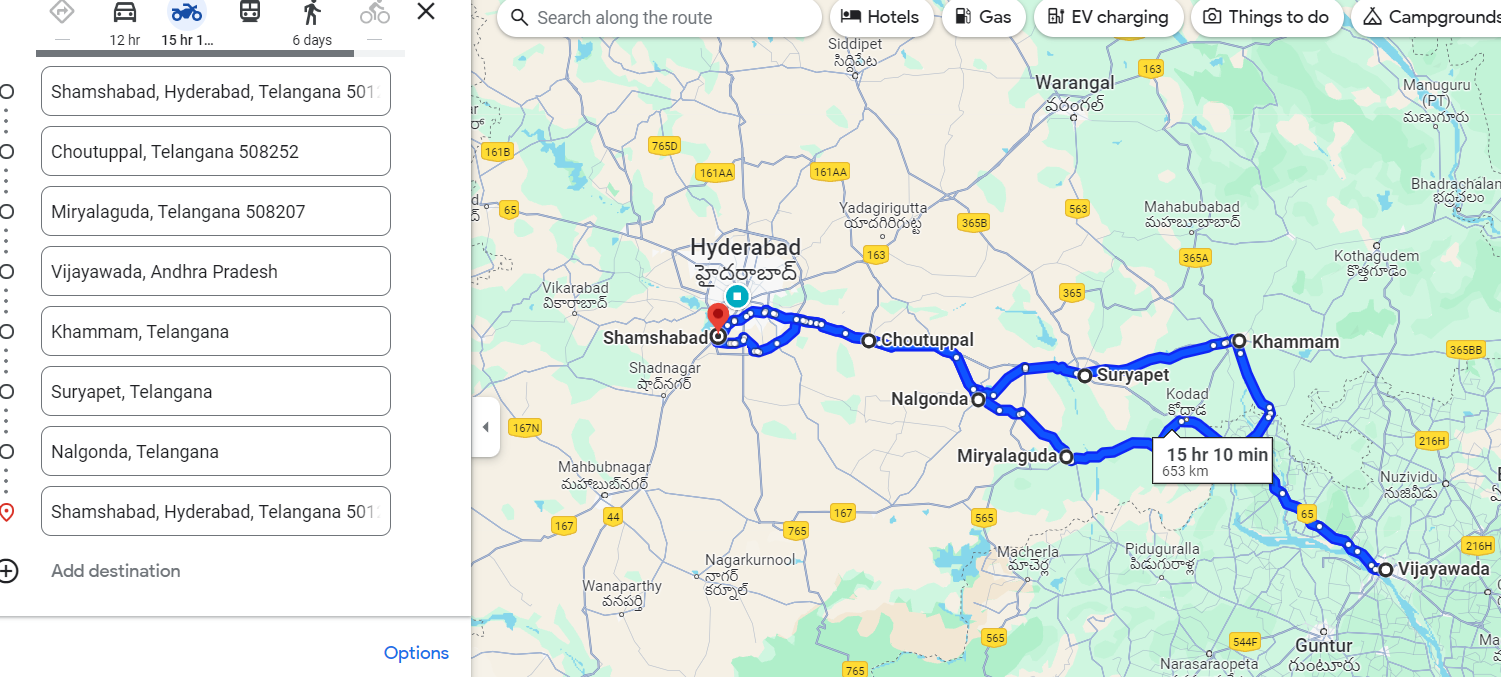

In [140]:
tmp[tmp["trip_uuid"] == "trip-153758895506669465"]

trip_uuid         trip_creation_time route_type  \
18784  trip-153758895506669465 2018-09-22 04:02:35.066945        FTL   
18785  trip-153758895506669465 2018-09-22 04:02:35.066945        FTL   
18786  trip-153758895506669465 2018-09-22 04:02:35.066945        FTL   
18787  trip-153758895506669465 2018-09-22 04:02:35.066945        FTL   
18788  trip-153758895506669465 2018-09-22 04:02:35.066945        FTL   
18789  trip-153758895506669465 2018-09-22 04:02:35.066945        FTL   
18790  trip-153758895506669465 2018-09-22 04:02:35.066945        FTL   
18791  trip-153758895506669465 2018-09-22 04:02:35.066945        FTL   
18792  trip-153758895506669465 2018-09-22 04:02:35.066945        FTL   
18793  trip-153758895506669465 2018-09-22 04:02:35.066945        FTL   
18794  trip-153758895506669465 2018-09-22 04:02:35.066945        FTL   
18795  trip-153758895506669465 2018-09-22 04:02:35.066945        FTL   
18796  trip-153758895506669465 2018-09-22 04:02:35.066945        FTL   
18797  trip-153758895506669465 2018-09-22 04:02:35.066945        FTL   
18798  trip-153758895506669465 2018-09-22 04:02:35.066945        FTL   
18799  trip-153758895506669465 2018-09-22 04:02:35.066945        FTL   
18800  trip-153758895506669465 2018-09-22 04:02:35.066945        FTL   
18801  trip-153758895506669465 2018-09-22 04:02:35.066945        FTL   
18802  trip-153758895506669465 2018-09-22 04:02:35.066945        FTL   
18803  trip-153758895506669465 2018-09-22 04:02:35.066945        FTL   
18804  trip-153758895506669465 2018-09-22 04:02:35.066945        FTL   
18805  trip-153758895506669465 2018-09-22 04:02:35.066945        FTL   
18806  trip-153758895506669465 2018-09-22 04:02:35.066945        FTL   
18807  trip-153758895506669465 2018-09-22 04:02:35.066945        FTL   
18808  trip-153758895506669465 2018-09-22 04:02:35.066945        FTL   
18809  trip-153758895506669465 2018-09-22 04:02:35.066945        FTL   

                         source_name               destination_name  \
18784           Guwahati_Hub (Assam)      Rangia_HosptlRd_D (Assam)   
18785           Guwahati_Hub (Assam)      Rangia_HosptlRd_D (Assam)   
18786     Nalbari_Bhgtpura_D (Assam)     Barpeta_ShivBari_D (Assam)   
18787     Nalbari_Bhgtpura_D (Assam)     Barpeta_ShivBari_D (Assam)   
18788     Nalbari_Bhgtpura_D (Assam)     Barpeta_ShivBari_D (Assam)   
18789     Barpeta_ShivBari_D (Assam)  Bongaigaon_Chpaguri_D (Assam)   
18790     Barpeta_ShivBari_D (Assam)  Bongaigaon_Chpaguri_D (Assam)   
18791     Barpeta_ShivBari_D (Assam)  Bongaigaon_Chpaguri_D (Assam)   
18792  Bongaigaon_Chpaguri_D (Assam)   Kokrajhar_PigonDPP_D (Assam)   
18793  Bongaigaon_Chpaguri_D (Assam)   Kokrajhar_PigonDPP_D (Assam)   
18794   Kokrajhar_PigonDPP_D (Assam)      Dhubri_Tetultol_D (Assam)   
18795   Kokrajhar_PigonDPP_D (Assam)      Dhubri_Tetultol_D (Assam)   
18796   Kokrajhar_PigonDPP_D (Assam)      Dhubri_Tetultol_D (Assam)   
18797      Dhubri_Tetultol_D (Assam)   Bilasipara_Wardno5_D (Assam)   
18798      Dhubri_Tetultol_D (Assam)   Bilasipara_Wardno5_D (Assam)   
18799   Bilasipara_Wardno5_D (Assam)    Lakhipur_WrdN4DPP_D (Assam)   
18800   Bilasipara_Wardno5_D (Assam)    Lakhipur_WrdN4DPP_D (Assam)   
18801   Bilasipara_Wardno5_D (Assam)    Lakhipur_WrdN4DPP_D (Assam)   
18802    Tura_Sracmplx_D (Meghalaya)           Guwahati_Hub (Assam)   
18803    Tura_Sracmplx_D (Meghalaya)           Guwahati_Hub (Assam)   
18804    Tura_Sracmplx_D (Meghalaya)           Guwahati_Hub (Assam)   
18805    Tura_Sracmplx_D (Meghalaya)           Guwahati_Hub (Assam)   
18806    Tura_Sracmplx_D (Meghalaya)           Guwahati_Hub (Assam)   
18807    Tura_Sracmplx_D (Meghalaya)           Guwahati_Hub (Assam)   
18808    Tura_Sracmplx_D (Meghalaya)           Guwahati_Hub (Assam)   
18809    Tura_Sracmplx_D (Meghalaya)           Guwahati_Hub (Assam)   

                    od_start_time                 od_end_time  actual_time  \
18784  2018-09-22 04:02:35.066945  2018-09-22 11:11:07.624473         32.0   
18

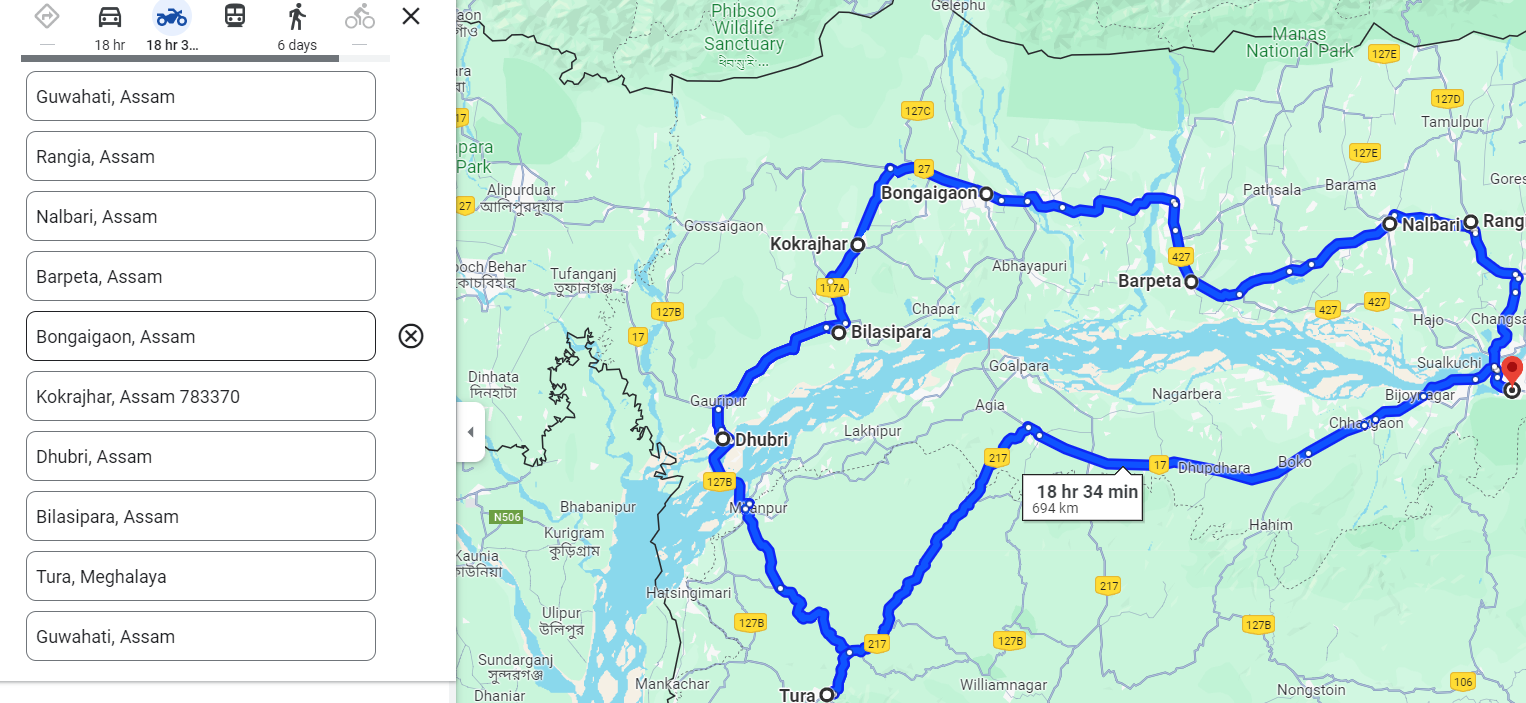

# Business Insights:

1. There is 68.79 % of FTL and 31 % of Carting route type.
2. The data is only for 2 months of 2018 (sept and october).
3. Around 2-3% of orders for route type carting are between bangalore to bangalore airport.
4. For 4.89 % of carting orders bangalore airport is either source or destination.
5. For 18 % of carting orders karnataka is either source or destination.
6. For 19 % of the carting orders Maharashtra is either source or destination.
7. For route_type carting Pappadahandi_Central_DPP_2 (Orissa) to Visakhapatnam_Gajuwaka_IP (Andhra Pradesh) is the most time consuming with high distance.
8. The route Gonda_KotwaliN_D (Uttar Pradesh) to Tulsipur_Central_DPP_1 (Uttar Pradesh)	is only 70 distance apart but took around 2536.0 time.
9. Gurugram,Bengaluru tops for highest no. of  orders.
10. State maharashtra and karnataka tops for trip source  and destination with joint 13% of total orders from each.
11. Gurugram with 14% and Bhiwandi with 10% came out to be top source for orders.
12. Bangalore with wooping 25% came out to be top destination for orders.
13. For orders between state to state Maharashtra tops with 16% annd karnataka with 15%.
14. Lets talk about the busiest routes:
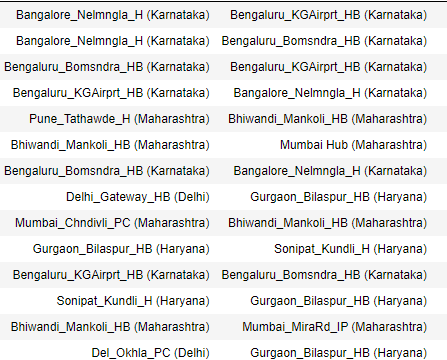
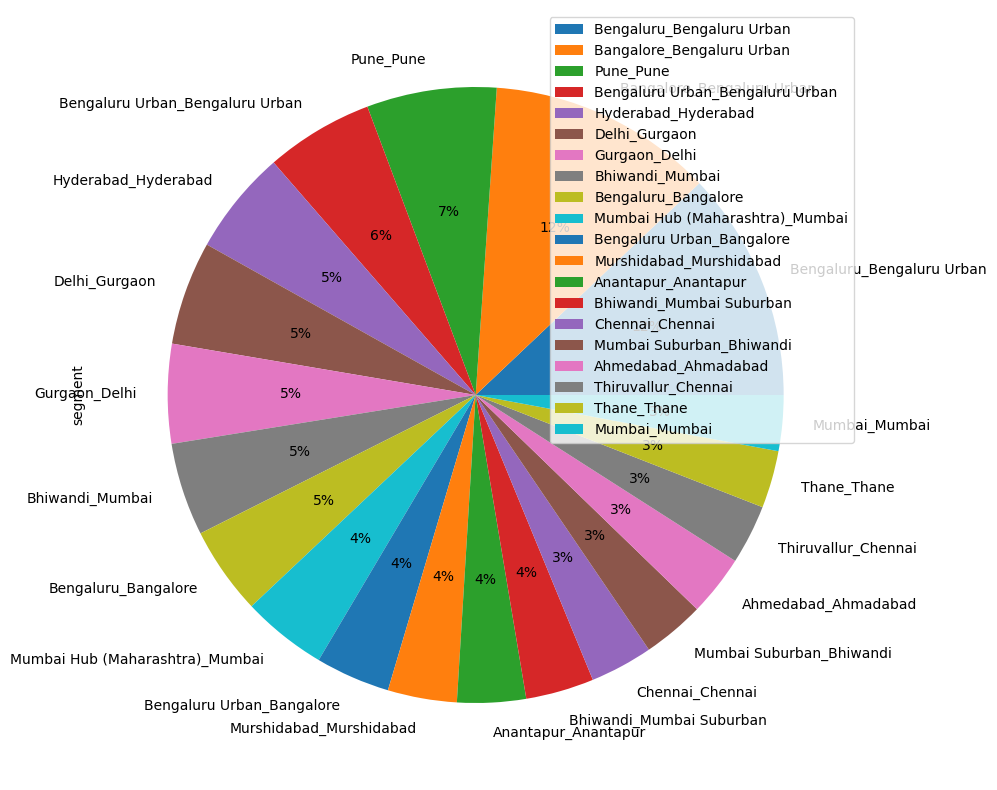
Majority of them are Bangalore inter city and Gurugram to delhi.
15. Lets see the most time consuming route:
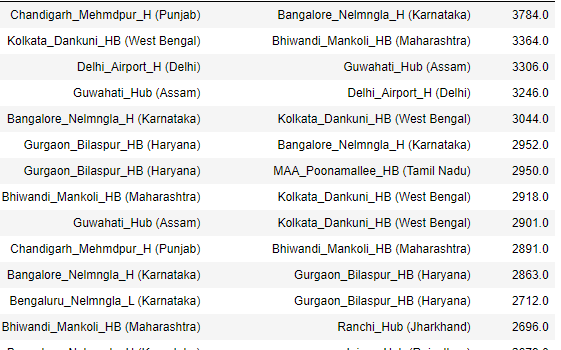






15. Busiest city by state

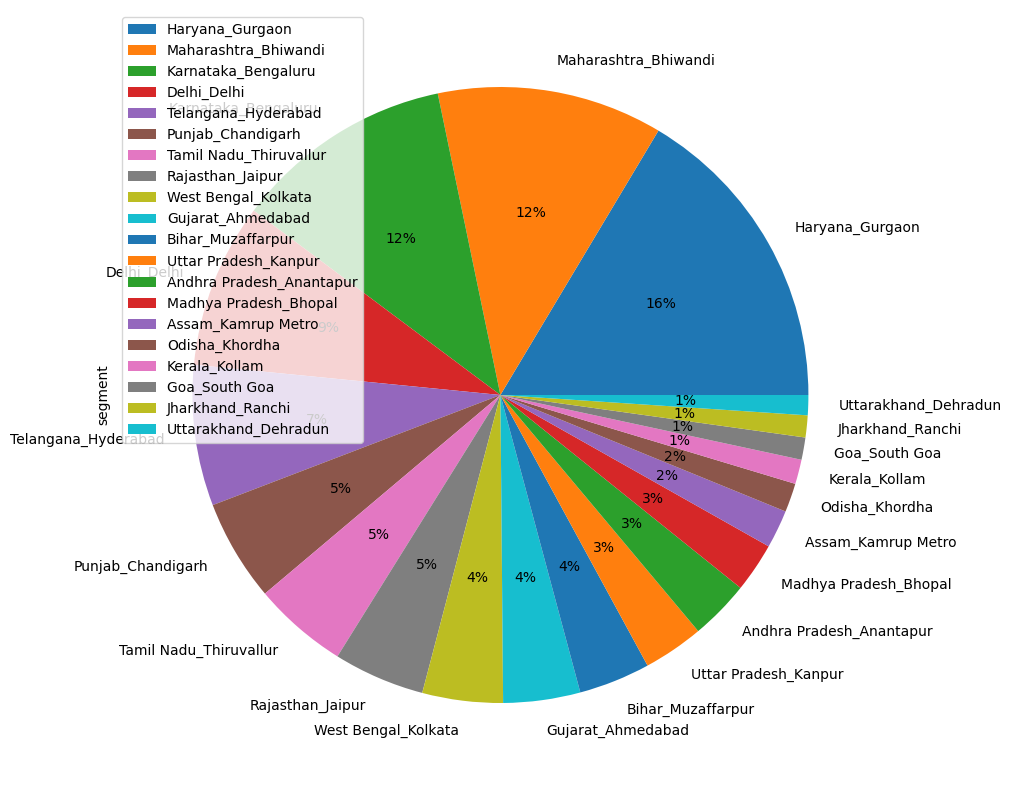

for short routes high time consumption

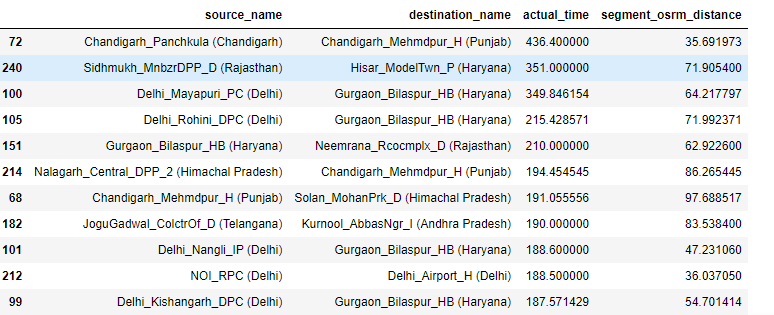

16. The average actual time for a trip is a greater than that of osmr_time not by chance factor.
17. The average actual time for a trip is equal to average segment_actual_time.
18. The segment_osrm_time for a route/trip is always greater than that of osrm_time.
19. The average segment_osrm_distance is greater than that of osrm_distance.

20. Fastest routes
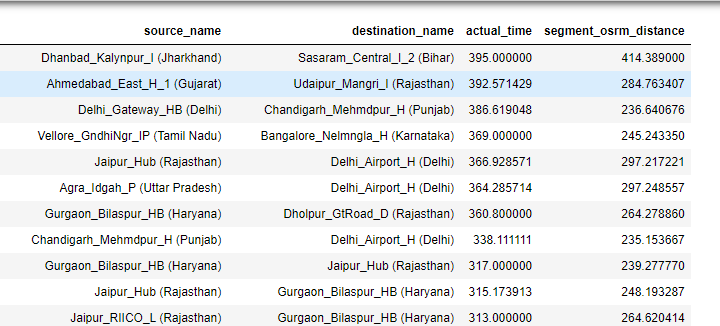

# Recommendations

1. There's lots of order shipment between banagalore city and bangalore airport. Adding more carting vehicles will help in orders TAT.
2. Karnataka and Bangalore has the most number of intra city orders. Therefore Adding more carting vehicles will help in shipment's TAT.
3. Adding more Delhivery service station in city like Gurugram,Banagalore,Bhiwandi as they are the main hub to process orders.
4. Company have to look into routes like :chandigarh to mehmdpur,sidmukh to hisar,Delhi to Gurugram,Gurugram to Nimrana,chandigarh to solan. Why the distance is so less but time is too high?
5. For few routes like delhi to delhi airport, Gurugram to delhi airport, bengalore to bengalore airport the avg time is too high.These are short distance trips so setting up the trip time off the peak hours should be the idle approach.
6. Prime delivery option for fastest routes like Dhanbad-> Bihar,Ahemdabad->Udaipur,Delhi->chandigarh,Gurugram->Jaipur